In [26]:
import os
import logging

import re
import glob
import numpy as np
from scipy import stats
from collections import OrderedDict
import json
import SimpleITK as sitk
import vtk
import matplotlib.pyplot as plt
import itk
import cv2
from itkwidgets import view
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid

try:
    import ipyvolume as ipv
except Exception as e:
    print('no ipyvolume installed')

# change working directory to project root
import platform
if platform.system() is "Windows":
    os.chdir('E:\\sven\\git\\cardio')
else:
    os.chdir('/Users/minority/Code/Git/cardio')
print(os.getcwd())

from src.utils.utils_io import Console_and_file_logger, save_plot, get_metadata_maybe, ensure_dir
from src.utils.file_wrapper.app.Files import Basefile, Dicomfile
from src.utils.file_wrapper.app.IO import FileWalker
from src.utils.myshow import myshow, myshow3d
from src.visualization.visualize import plot_3d_vol, plot_4d_vol

from ipywidgets import interact
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%reload_ext autoreload
%autoreload 2
%matplotlib inline
Console_and_file_logger('visualize_volumes', logging.INFO)


E:\sven\git\cardio


In [23]:

def plot_3d_vol(img_3d, timestep=0, save=False, path='temp/'):
    
    if img_3d.max() == 0:
        logging.debug('timestep: {} - no values'.format(timestep))
    else:
        logging.debug('timestep: {} - plotting'.format(timestep))
    
        # define the number of subplots = no of slices in z-direction
        fig, ax = plt.subplots(1, img_3d.shape[0], figsize=[25, 8])

        n = 0
        for slice in range(img_3d.shape[0]):
            ax[n].imshow(img_3d[slice, :, :])
            ax[n].set_xticks([])
            ax[n].set_yticks([])
            ax[n].set_title('z-axis: {}'.format(slice), color='r')
            n += 1


        fig.subplots_adjust(wspace=0, hspace=0)
        if save:
            save_plot(fig,path, str(timestep), override=True)
        plt.show()
    


In [24]:
def plot_4d_vol(img_4d, timesteps=[0], save=False, path='temp/'):
    
    # filter all empty volumes in a 4d numpy array
    # creates a grid with # timesteps * z-slices
    # saves all slices as fig
    # expects nda with t, z, x, y
    
    if len(timesteps) <=1: # add first volume if no timesteps found
        logging.info('Only {} timesteps found for: {}'.format(len(timesteps), path))
        timesteps.append(0)
    assert(len(timesteps) == img_4d.shape[0]), 'timeteps does not match'
        
    # define the number of subplots
    # timesteps * z-slices
    t_size = int(2 * img_4d.shape[1])
    z_size = int(2.5 * len(timesteps))
    fig, ax = plt.subplots(len(timesteps), img_4d.shape[1], figsize=[t_size, z_size])
    print(timesteps)
    for t_, img_3d in enumerate(img_4d): # traverse trough time

        for z, slice in enumerate(img_3d): # traverse through the z-axis
            # show slice and delete ticks
            ax[t_][z].imshow(slice)
            ax[t_][z].set_xticks([])
            ax[t_][z].set_yticks([])
            #ax[t_][z].set_aspect('equal')
            if t_ == 0: # set title before first row
                ax[t_][z].set_title('z-axis: {}'.format(z), color='r')
            if z == 0: # set ylabel before first column
                ax[t_][z].set_ylabel('t-axis: {}'.format(timesteps[t_]), color='r')

    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    
    
    if save:
        save_plot(fig, path, '4d_volume', override=True, tight=False)
    else:
        fig.show()
        

In [21]:
def filter_4d_vol(sitk_img_4d, save=False, path='temp/', slice_threshold=2):
    
    """
    filter emtpy slices along axis 0
    expect a 4d numpy array with shape t, z, x, y
    Returns 
    """
    
    nda_4d = sitk.GetArrayFromImage(sitk_img_4d)
    
    # get indexes for masked volumes
    timesteps = [t for t, img in enumerate(nda_4d) if img.max() > 0]
    print(timesteps)
    filtered_nda = nda_4d[timesteps]

    if save:
        ensure_dir(path)
        # write one nrrd file per masked timestep to disk
        for t in timesteps: # traverse trough time
            
            # extract each timestep as volume
            img_3d = sitk.GetImageFromArray(nda_4d[t])
            masked_slices = [1 for slice in nda_4d[t] if slice.max()>1]
            
            if sum(masked_slices) > slice_threshold: # save only volumes with more slices masked than slice threshold
                # copy metadata
                for tag in sitk_img_4d.GetMetaDataKeys():
                    value = get_metadata_maybe(sitk_img_4d, tag)
                    img_3d.SetMetaData(tag, value)

                # save to disk
                sitk.WriteImage(img_3d, os.path.join(path, str(t) + '.nrrd'))
    

    
    return filtered_nda, timesteps
            

In [20]:
@interact
def filter_empty_timesteps(filename=glob.glob('data/processed/nrrd_volume_export_new_1/*mask.nrrd'), save_nrrd=False, save_img=False):
    
    file_name = os.path.basename(filename).split('.')[0]
    nrrd_export_path = os.path.join('data/raw/tetra/3d/',file_name)
    figure_export_path = os.path.join('reports/figures/tetra/',file_name)
    
    img = sitk.ReadImage(filename)
    img_nda = sitk.GetArrayFromImage(img)
    logging.info('filename: {}'.format(filename))
    logging.info('shape: {}'.format(img_nda.shape))
    logging.info('max: {}'.format(img_nda.max()))
    logging.info('min: {}'.format(img_nda.min()))
    plt.tight_layout()
    
    filtered_nda, timesteps = filter_4d_vol(img, save=save_nrrd, path=nrrd_export_path)
    plot_4d_vol(filtered_nda, timesteps=timesteps, save=save_img, path=figure_export_path)
    

interactive(children=(Dropdown(description='filename', options=('data/processed/nrrd_volume_export_new_1\\0003…

In [6]:
# select by filename
@interact
def show_4d_volumes(file_ = glob.glob('reports/figures/tetra/**/*volume.png')):
    print(file_)
    display(Image(filename=file_))


interactive(children=(Dropdown(description='file_', options=('reports/figures/tetra\\0003-04NEJQUZ-2007-03-13_…

In [7]:
# select image with slider, faster
@interact
def show_4d_volumes(index=(0,len(glob.glob('reports/figures/tetra/**/*volume.png')),1)):
    
    file_ = glob.glob('reports/figures/tetra/**/*volume.png')
    print(file_[index])
    display(Image(filename=file_[index]))


    


interactive(children=(IntSlider(value=101, description='index', max=202), Output()), _dom_classes=('widget-int…

In [ ]:
# load all train mask files, filter empty mask volumes and save them

folder = 'data/processed/nrrd_volume_export_new_1/*mask.nrrd'
total = len(glob.glob(folder))

for i,file_name in enumerate(glob.glob(folder)):
    
    logging.info('volume {} of total {}'.format(i, total))
    filter_empty_timesteps(filename=file_name, save_nrrd=True, save_img=True)

2019-04-05 00:41:09,926 INFO volume 0 of total 202
2019-04-05 00:41:10,509 INFO filename: data/processed/nrrd_volume_export_new_1\0003-04NEJQUZ-2007-03-13_volume_mask.nrrd
2019-04-05 00:41:10,511 INFO shape: (25, 16, 256, 256)
2019-04-05 00:41:10,547 INFO max: 3.0
2019-04-05 00:41:10,584 INFO min: 0.0


[5, 12, 16, 20, 23]
[5, 12, 16, 20, 23]


2019-04-05 00:41:13,957 INFO volume 1 of total 202
2019-04-05 00:41:14,346 INFO filename: data/processed/nrrd_volume_export_new_1\0006-0AE4R74L-1900-01-01_volume_mask.nrrd
2019-04-05 00:41:14,347 INFO shape: (13, 11, 192, 144)
2019-04-05 00:41:14,359 INFO max: 3
2019-04-05 00:41:14,370 INFO min: 0


[1, 3, 6, 10, 12]
[1, 3, 6, 10, 12]


2019-04-05 00:41:15,889 INFO volume 2 of total 202
2019-04-05 00:41:19,028 INFO filename: data/processed/nrrd_volume_export_new_1\0007-0HQQW4ZN-2007-05-23_volume_mask.nrrd
2019-04-05 00:41:19,030 INFO shape: (25, 10, 256, 256)
2019-04-05 00:41:19,055 INFO max: 3.0
2019-04-05 00:41:19,078 INFO min: 0.0


[6, 10, 15, 21, 24]
[6, 10, 15, 21, 24]


2019-04-05 00:41:21,733 INFO volume 3 of total 202
2019-04-05 00:41:23,284 INFO filename: data/processed/nrrd_volume_export_new_1\0008-0PTV75MP-2005-06-27_volume_mask.nrrd
2019-04-05 00:41:23,287 INFO shape: (14, 12, 256, 256)
2019-04-05 00:41:23,303 INFO max: 3.0
2019-04-05 00:41:23,319 INFO min: 0.0


[0, 3, 7, 11, 13]
[0, 3, 7, 11, 13]


2019-04-05 00:41:25,401 INFO volume 4 of total 202
2019-04-05 00:41:29,414 INFO filename: data/processed/nrrd_volume_export_new_1\0010-0RPELLU8-2007-02-13_volume_mask.nrrd
2019-04-05 00:41:29,416 INFO shape: (25, 13, 288, 288)
2019-04-05 00:41:29,457 INFO max: 3.0
2019-04-05 00:41:29,496 INFO min: 0.0


[3, 6, 11, 19, 24]
[3, 6, 11, 19, 24]


2019-04-05 00:41:32,634 INFO volume 5 of total 202
2019-04-05 00:41:35,397 INFO filename: data/processed/nrrd_volume_export_new_1\0013-13JLP3HN-2007-05-22_volume_mask.nrrd
2019-04-05 00:41:35,399 INFO shape: (25, 16, 320, 320)
2019-04-05 00:41:35,454 INFO max: 3.0
2019-04-05 00:41:35,510 INFO min: 0.0


[6, 12, 18, 22, 24]
[6, 12, 18, 22, 24]


2019-04-05 00:41:39,753 INFO volume 6 of total 202
2019-04-05 00:41:41,732 INFO filename: data/processed/nrrd_volume_export_new_1\0014-1DRHF745-2005-09-01_volume_mask.nrrd
2019-04-05 00:41:41,734 INFO shape: (17, 18, 256, 256)
2019-04-05 00:41:41,759 INFO max: 3.0
2019-04-05 00:41:41,784 INFO min: 0.0


[3, 7, 11, 14, 16]
[3, 7, 11, 14, 16]


2019-04-05 00:41:45,476 INFO volume 7 of total 202
2019-04-05 00:41:46,270 INFO filename: data/processed/nrrd_volume_export_new_1\0016-1E4PF7MR-2006-07-06_volume_mask.nrrd
2019-04-05 00:41:46,273 INFO shape: (22, 14, 256, 256)
2019-04-05 00:41:46,335 INFO max: 3
2019-04-05 00:41:46,391 INFO min: 0


[0, 3, 10, 13, 19]
[0, 3, 10, 13, 19]


2019-04-05 00:41:48,427 INFO volume 8 of total 202
2019-04-05 00:41:49,944 INFO filename: data/processed/nrrd_volume_export_new_1\0018-1E8MCV9L-2005-12-15_volume_mask.nrrd
2019-04-05 00:41:49,946 INFO shape: (20, 14, 256, 256)
2019-04-05 00:41:49,974 INFO max: 3.0
2019-04-05 00:41:50,001 INFO min: 0.0


[0, 4, 9, 11, 15]
[0, 4, 9, 11, 15]


2019-04-05 00:41:53,119 INFO volume 9 of total 202
2019-04-05 00:41:53,483 INFO filename: data/processed/nrrd_volume_export_new_1\0019-1EMMCVKN-2006-06-29_volume_mask.nrrd
2019-04-05 00:41:53,486 INFO shape: (20, 12, 256, 256)
2019-04-05 00:41:53,531 INFO max: 3
2019-04-05 00:41:53,573 INFO min: 0


[4, 9, 13, 17, 19]
[4, 9, 13, 17, 19]


2019-04-05 00:41:55,626 INFO volume 10 of total 202
2019-04-05 00:41:58,318 INFO filename: data/processed/nrrd_volume_export_new_1\0034-1Y8H8XLE-2007-03-22_volume_mask.nrrd
2019-04-05 00:41:58,320 INFO shape: (25, 22, 256, 256)
2019-04-05 00:41:58,372 INFO max: 3.0
2019-04-05 00:41:58,421 INFO min: 0.0


[0, 5, 10, 16, 22]
[0, 5, 10, 16, 22]


2019-04-05 00:42:02,615 INFO volume 11 of total 202
2019-04-05 00:42:04,827 INFO filename: data/processed/nrrd_volume_export_new_1\0042-24YLF77L-2007-11-19_volume_mask.nrrd
2019-04-05 00:42:04,829 INFO shape: (30, 13, 320, 320)
2019-04-05 00:42:04,890 INFO max: 3.0
2019-04-05 00:42:04,952 INFO min: 0.0


[3, 7, 12, 23, 27]
[3, 7, 12, 23, 27]


2019-04-05 00:42:08,242 INFO volume 12 of total 202
2019-04-05 00:42:10,106 INFO filename: data/processed/nrrd_volume_export_new_1\0046-2CVUG1C5-2006-09-06_volume_mask.nrrd
2019-04-05 00:42:10,108 INFO shape: (36, 14, 512, 512)
2019-04-05 00:42:10,471 INFO max: 3
2019-04-05 00:42:10,845 INFO min: 0


[4, 10, 17, 25, 31]
[4, 10, 17, 25, 31]


2019-04-05 00:42:14,456 INFO volume 13 of total 202
2019-04-05 00:42:15,526 INFO filename: data/processed/nrrd_volume_export_new_1\0049-2FUH59VD-2006-08-24_volume_mask.nrrd
2019-04-05 00:42:15,528 INFO shape: (20, 15, 256, 256)
2019-04-05 00:42:15,560 INFO max: 3.0
2019-04-05 00:42:15,593 INFO min: 0.0


[3, 8, 12, 16, 19]
[3, 8, 12, 16, 19]


2019-04-05 00:42:18,489 INFO volume 14 of total 202
2019-04-05 00:42:19,460 INFO filename: data/processed/nrrd_volume_export_new_1\0051-2HQVK81W-2005-03-11_volume_mask.nrrd
2019-04-05 00:42:19,462 INFO shape: (16, 16, 256, 256)
2019-04-05 00:42:19,491 INFO max: 3.0
2019-04-05 00:42:19,516 INFO min: 0.0


[3, 6, 11, 14, 15]
[3, 6, 11, 14, 15]


2019-04-05 00:42:22,629 INFO volume 15 of total 202
2019-04-05 00:42:23,826 INFO filename: data/processed/nrrd_volume_export_new_1\0055-2V8HJLHN-2005-08-30_volume_mask.nrrd
2019-04-05 00:42:23,828 INFO shape: (20, 13, 256, 256)
2019-04-05 00:42:23,851 INFO max: 3.0
2019-04-05 00:42:23,878 INFO min: 0.0


[0, 4, 10, 16, 18]
[0, 4, 10, 16, 18]


2019-04-05 00:42:26,618 INFO volume 16 of total 202
2019-04-05 00:42:27,485 INFO filename: data/processed/nrrd_volume_export_new_1\0057-2VRMJ3ZF-2006-01-17_volume_mask.nrrd
2019-04-05 00:42:27,488 INFO shape: (20, 12, 256, 256)
2019-04-05 00:42:27,512 INFO max: 3.0
2019-04-05 00:42:27,538 INFO min: 0.0


[1, 4, 9, 13, 18]
[1, 4, 9, 13, 18]


2019-04-05 00:42:30,273 INFO volume 17 of total 202
2019-04-05 00:42:30,466 INFO filename: data/processed/nrrd_volume_export_new_1\0059-2WHFP73X-2007-03-28_volume_mask.nrrd
2019-04-05 00:42:30,468 INFO shape: (25, 11, 192, 132)
2019-04-05 00:42:30,488 INFO max: 3
2019-04-05 00:42:30,508 INFO min: 0


[2, 7, 13, 17, 20]
[2, 7, 13, 17, 20]


2019-04-05 00:42:32,181 INFO volume 18 of total 202
2019-04-05 00:42:33,123 INFO filename: data/processed/nrrd_volume_export_new_1\0061-2X1HM1YK-2006-08-01_volume_mask.nrrd
2019-04-05 00:42:33,125 INFO shape: (20, 12, 256, 256)
2019-04-05 00:42:33,148 INFO max: 3.0
2019-04-05 00:42:33,174 INFO min: 0.0


[2, 7, 11, 13, 15]
[2, 7, 11, 13, 15]


2019-04-05 00:42:35,722 INFO volume 19 of total 202
2019-04-05 00:42:36,718 INFO filename: data/processed/nrrd_volume_export_new_1\0064-2XRR719Z-2005-05-02_volume_mask.nrrd
2019-04-05 00:42:36,720 INFO shape: (20, 14, 256, 256)
2019-04-05 00:42:36,757 INFO max: 3.0
2019-04-05 00:42:36,784 INFO min: 0.0


[4, 9, 15, 17, 19]
[4, 9, 15, 17, 19]


2019-04-05 00:42:39,398 INFO volume 20 of total 202
2019-04-05 00:42:40,114 INFO filename: data/processed/nrrd_volume_export_new_1\0066-2Y9U5LLC-2006-07-24_volume_mask.nrrd
2019-04-05 00:42:40,116 INFO shape: (16, 12, 256, 256)
2019-04-05 00:42:40,138 INFO max: 3.0
2019-04-05 00:42:40,158 INFO min: 0.0


[3, 6, 10, 14, 15]
[3, 6, 10, 14, 15]


2019-04-05 00:42:42,351 INFO volume 21 of total 202
2019-04-05 00:42:43,587 INFO filename: data/processed/nrrd_volume_export_new_1\0068-3E8U83K5-2006-04-01_volume_mask.nrrd
2019-04-05 00:42:43,589 INFO shape: (20, 16, 256, 256)
2019-04-05 00:42:43,623 INFO max: 3.0
2019-04-05 00:42:43,655 INFO min: 0.0


[4, 10, 12, 17, 19]
[4, 10, 12, 17, 19]


2019-04-05 00:42:46,545 INFO volume 22 of total 202
2019-04-05 00:42:48,360 INFO filename: data/processed/nrrd_volume_export_new_1\0070-3E90836W-2006-05-23_volume_mask.nrrd
2019-04-05 00:42:48,364 INFO shape: (34, 15, 512, 512)
2019-04-05 00:42:48,728 INFO max: 3
2019-04-05 00:42:48,992 INFO min: 0


[5, 11, 19, 29, 33]
[5, 11, 19, 29, 33]


2019-04-05 00:42:52,678 INFO volume 23 of total 202
2019-04-05 00:42:53,460 INFO filename: data/processed/nrrd_volume_export_new_1\0073-3EX293QC-2006-06-19_volume_mask.nrrd
2019-04-05 00:42:53,462 INFO shape: (20, 12, 256, 256)
2019-04-05 00:42:53,482 INFO max: 3.0
2019-04-05 00:42:53,503 INFO min: 0.0


[0, 4, 9, 11, 15]
[0, 4, 9, 11, 15]


2019-04-05 00:42:55,508 INFO volume 24 of total 202
2019-04-05 00:42:57,089 INFO filename: data/processed/nrrd_volume_export_new_1\0074-3HQQHA3N-2006-03-01_volume_mask.nrrd
2019-04-05 00:42:57,091 INFO shape: (25, 18, 256, 256)
2019-04-05 00:42:57,135 INFO max: 3.0
2019-04-05 00:42:57,188 INFO min: 0.0


[5, 9, 13, 18, 23]
[5, 9, 13, 18, 23]


2019-04-05 00:43:00,871 INFO volume 25 of total 202
2019-04-05 00:43:02,181 INFO filename: data/processed/nrrd_volume_export_new_1\0076-3HYXWJWW-2006-11-17_volume_mask.nrrd
2019-04-05 00:43:02,183 INFO shape: (20, 15, 256, 256)
2019-04-05 00:43:02,214 INFO max: 3.0
2019-04-05 00:43:02,247 INFO min: 0.0


[3, 6, 10, 17, 19]
[3, 6, 10, 17, 19]


2019-04-05 00:43:05,155 INFO volume 26 of total 202
2019-04-05 00:43:05,557 INFO filename: data/processed/nrrd_volume_export_new_1\0081-3U3KT9LV-2006-12-19_volume_mask.nrrd
2019-04-05 00:43:05,558 INFO shape: (25, 12, 192, 156)
2019-04-05 00:43:05,582 INFO max: 3
2019-04-05 00:43:05,606 INFO min: 0


[4, 8, 13, 17, 22]
[4, 8, 13, 17, 22]


2019-04-05 00:43:07,555 INFO volume 27 of total 202
2019-04-05 00:43:08,246 INFO filename: data/processed/nrrd_volume_export_new_1\0084-3WRWDJPC-2004-05-26_volume_mask.nrrd
2019-04-05 00:43:08,248 INFO shape: (15, 13, 256, 256)
2019-04-05 00:43:08,266 INFO max: 3.0
2019-04-05 00:43:08,287 INFO min: 0.0


[2, 5, 8, 11, 13]
[2, 5, 8, 11, 13]


2019-04-05 00:43:10,453 INFO volume 28 of total 202
2019-04-05 00:43:12,153 INFO filename: data/processed/nrrd_volume_export_new_1\0086-44U3AGET-2006-08-01_volume_mask.nrrd
2019-04-05 00:43:12,155 INFO shape: (25, 18, 256, 256)
2019-04-05 00:43:12,202 INFO max: 3.0
2019-04-05 00:43:12,247 INFO min: 0.0


[3, 7, 14, 17, 19]
[3, 7, 14, 17, 19]


2019-04-05 00:43:15,861 INFO volume 29 of total 202
2019-04-05 00:43:16,762 INFO filename: data/processed/nrrd_volume_export_new_1\0090-49RHVC6C-2005-11-22_volume_mask.nrrd
2019-04-05 00:43:16,765 INFO shape: (20, 13, 256, 256)
2019-04-05 00:43:16,794 INFO max: 3.0
2019-04-05 00:43:16,813 INFO min: 0.0


[3, 7, 11, 15, 17]
[3, 7, 11, 15, 17]


2019-04-05 00:43:19,026 INFO volume 30 of total 202
2019-04-05 00:43:19,373 INFO filename: data/processed/nrrd_volume_export_new_1\0092-4A4PVCYL-2006-09-01_volume_mask.nrrd
2019-04-05 00:43:19,375 INFO shape: (20, 14, 256, 256)
2019-04-05 00:43:19,427 INFO max: 3
2019-04-05 00:43:19,477 INFO min: 0


[2, 6, 10, 15, 17]
[2, 6, 10, 15, 17]


2019-04-05 00:43:21,462 INFO volume 31 of total 202
2019-04-05 00:43:22,527 INFO filename: data/processed/nrrd_volume_export_new_1\0095-4A8MPQF4-2005-03-15_volume_mask.nrrd
2019-04-05 00:43:22,529 INFO shape: (20, 14, 256, 256)
2019-04-05 00:43:22,551 INFO max: 3.0
2019-04-05 00:43:22,581 INFO min: 0.0


[3, 7, 13, 17, 19]
[3, 7, 13, 17, 19]


2019-04-05 00:43:25,355 INFO volume 32 of total 202
2019-04-05 00:43:25,696 INFO filename: data/processed/nrrd_volume_export_new_1\0100-4HD5X727-2006-02-16_volume_mask.nrrd
2019-04-05 00:43:25,698 INFO shape: (50, 14, 192, 156)
2019-04-05 00:43:25,748 INFO max: 3
2019-04-05 00:43:25,797 INFO min: 0


[6, 7, 16, 17, 28, 29, 38, 39, 46, 47]
[6, 7, 16, 17, 28, 29, 38, 39, 46, 47]


2019-04-05 00:43:30,303 INFO volume 33 of total 202
2019-04-05 00:43:30,595 INFO filename: data/processed/nrrd_volume_export_new_1\0106-4PWV5NAX-2008-09-30_volume_mask.nrrd
2019-04-05 00:43:30,596 INFO shape: (25, 15, 192, 156)
2019-04-05 00:43:30,633 INFO max: 3
2019-04-05 00:43:30,668 INFO min: 0


[4, 7, 11, 17, 22]
[4, 7, 11, 17, 22]


2019-04-05 00:43:32,822 INFO volume 34 of total 202
2019-04-05 00:43:33,044 INFO filename: data/processed/nrrd_volume_export_new_1\0107-4Q0TDELR-2007-03-29_volume_mask.nrrd
2019-04-05 00:43:33,046 INFO shape: (25, 14, 192, 156)
2019-04-05 00:43:33,071 INFO max: 3
2019-04-05 00:43:33,099 INFO min: 0


[2, 7, 12, 19, 22]
[2, 7, 12, 19, 22]


2019-04-05 00:43:35,028 INFO volume 35 of total 202
2019-04-05 00:43:36,742 INFO filename: data/processed/nrrd_volume_export_new_1\0109-4QGENZMT-2007-02-22_volume_mask.nrrd
2019-04-05 00:43:36,744 INFO shape: (25, 14, 288, 288)
2019-04-05 00:43:36,805 INFO max: 3.0
2019-04-05 00:43:36,849 INFO min: 0.0


[4, 10, 16, 21, 24]
[4, 10, 16, 21, 24]


2019-04-05 00:43:39,856 INFO volume 36 of total 202
2019-04-05 00:43:40,734 INFO filename: data/processed/nrrd_volume_export_new_1\0116-5CXHN75U-2006-08-02_volume_mask.nrrd
2019-04-05 00:43:40,736 INFO shape: (20, 12, 256, 256)
2019-04-05 00:43:40,758 INFO max: 3.0
2019-04-05 00:43:40,777 INFO min: 0.0


[2, 7, 9, 16, 17]
[2, 7, 9, 16, 17]


2019-04-05 00:43:43,032 INFO volume 37 of total 202
2019-04-05 00:43:43,892 INFO filename: data/processed/nrrd_volume_export_new_1\0117-5JGEZLYC-2007-09-25_volume_mask.nrrd
2019-04-05 00:43:43,896 INFO shape: (25, 10, 256, 256)
2019-04-05 00:43:43,925 INFO max: 3.0
2019-04-05 00:43:43,953 INFO min: 0.0


[3, 8, 12, 19, 23]
[3, 8, 12, 19, 23]


2019-04-05 00:43:46,014 INFO volume 38 of total 202
2019-04-05 00:43:46,869 INFO filename: data/processed/nrrd_volume_export_new_1\0122-5RRMWQX2-2005-06-10_volume_mask.nrrd
2019-04-05 00:43:46,872 INFO shape: (20, 12, 256, 256)
2019-04-05 00:43:46,904 INFO max: 3.0
2019-04-05 00:43:46,932 INFO min: 0.0


[4, 9, 11, 16, 19]
[4, 9, 11, 16, 19]


2019-04-05 00:43:49,471 INFO volume 39 of total 202
2019-04-05 00:43:51,180 INFO filename: data/processed/nrrd_volume_export_new_1\0124-5T8DXCQ2-2006-10-01_volume_mask.nrrd
2019-04-05 00:43:51,182 INFO shape: (25, 18, 256, 256)
2019-04-05 00:43:51,224 INFO max: 3.0
2019-04-05 00:43:51,267 INFO min: 0.0


[3, 9, 12, 21, 23]
[3, 9, 12, 21, 23]


2019-04-05 00:43:54,760 INFO volume 40 of total 202
2019-04-05 00:43:55,746 INFO filename: data/processed/nrrd_volume_export_new_1\0127-5W8RFCJD-2005-04-18_volume_mask.nrrd
2019-04-05 00:43:55,748 INFO shape: (20, 14, 256, 256)
2019-04-05 00:43:55,774 INFO max: 3.0
2019-04-05 00:43:55,800 INFO min: 0.0


[2, 7, 11, 15, 19]
[2, 7, 11, 15, 19]


2019-04-05 00:43:57,953 INFO volume 41 of total 202
2019-04-05 00:43:58,215 INFO filename: data/processed/nrrd_volume_export_new_1\0129-5YX47QXL-2006-10-13_volume_mask.nrrd
2019-04-05 00:43:58,216 INFO shape: (25, 12, 192, 156)
2019-04-05 00:43:58,245 INFO max: 3
2019-04-05 00:43:58,274 INFO min: 0


[0, 6, 11, 12, 21]
[0, 6, 11, 12, 21]


2019-04-05 00:44:00,231 INFO volume 42 of total 202
2019-04-05 00:44:01,904 INFO filename: data/processed/nrrd_volume_export_new_1\0131-68UAYTYD-2005-10-01_volume_mask.nrrd
2019-04-05 00:44:01,908 INFO shape: (25, 18, 256, 256)
2019-04-05 00:44:01,952 INFO max: 3.0
2019-04-05 00:44:01,996 INFO min: 0.0


[0, 4, 8, 12, 22]
[0, 4, 8, 12, 22]


2019-04-05 00:44:05,472 INFO volume 43 of total 202
2019-04-05 00:44:06,470 INFO filename: data/processed/nrrd_volume_export_new_1\0133-6E5FAVTH-2007-03-28_volume_mask.nrrd
2019-04-05 00:44:06,472 INFO shape: (25, 10, 256, 256)
2019-04-05 00:44:06,494 INFO max: 3.0
2019-04-05 00:44:06,516 INFO min: 0.0


[5, 8, 12, 17, 24]
[5, 8, 12, 17, 24]


2019-04-05 00:44:08,676 INFO volume 44 of total 202
2019-04-05 00:44:10,111 INFO filename: data/processed/nrrd_volume_export_new_1\0136-6HYCWX3G-2006-11-13_volume_mask.nrrd
2019-04-05 00:44:10,112 INFO shape: (25, 16, 256, 256)
2019-04-05 00:44:10,151 INFO max: 3.0
2019-04-05 00:44:10,190 INFO min: 0.0


[2, 9, 14, 19, 20]
[2, 9, 14, 19, 20]


2019-04-05 00:44:13,357 INFO volume 45 of total 202
2019-04-05 00:44:14,242 INFO filename: data/processed/nrrd_volume_export_new_1\0137-6N9VDLAU-2006-07-06_volume_mask.nrrd
2019-04-05 00:44:14,244 INFO shape: (18, 12, 256, 256)
2019-04-05 00:44:14,263 INFO max: 3.0
2019-04-05 00:44:14,283 INFO min: 0.0


[0, 4, 9, 11, 15]
[0, 4, 9, 11, 15]


2019-04-05 00:44:16,390 INFO volume 46 of total 202
2019-04-05 00:44:17,968 INFO filename: data/processed/nrrd_volume_export_new_1\0141-73FTW74F-2006-11-28_volume_mask.nrrd
2019-04-05 00:44:17,971 INFO shape: (25, 14, 288, 288)
2019-04-05 00:44:18,022 INFO max: 3.0
2019-04-05 00:44:18,063 INFO min: 0.0


[4, 8, 12, 18, 22]
[4, 8, 12, 18, 22]


2019-04-05 00:44:21,196 INFO volume 47 of total 202
2019-04-05 00:44:22,659 INFO filename: data/processed/nrrd_volume_export_new_1\0143-75HTGLYY-2007-04-02_volume_mask.nrrd
2019-04-05 00:44:22,661 INFO shape: (25, 14, 256, 256)
2019-04-05 00:44:22,699 INFO max: 3.0
2019-04-05 00:44:22,733 INFO min: 0.0


[6, 12, 17, 21, 23]
[6, 12, 17, 21, 23]


2019-04-05 00:45:09,659 INFO volume 48 of total 202
2019-04-05 00:45:10,451 INFO filename: data/processed/nrrd_volume_export_new_1\0144-76RJ3Z26-2006-11-23_volume_mask.nrrd
2019-04-05 00:45:10,453 INFO shape: (20, 12, 256, 256)
2019-04-05 00:45:10,474 INFO max: 3.0
2019-04-05 00:45:10,495 INFO min: 0.0


[0, 6, 11, 13, 18]
[0, 6, 11, 13, 18]


2019-04-05 00:45:12,442 INFO volume 49 of total 202
2019-04-05 00:45:13,169 INFO filename: data/processed/nrrd_volume_export_new_1\0146-778N33YG-2006-09-25_volume_mask.nrrd
2019-04-05 00:45:13,171 INFO shape: (18, 12, 256, 256)
2019-04-05 00:45:13,192 INFO max: 3.0
2019-04-05 00:45:13,209 INFO min: 0.0


[0, 2, 6, 8, 15]
[0, 2, 6, 8, 15]


2019-04-05 00:45:15,542 INFO volume 50 of total 202
2019-04-05 00:45:17,042 INFO filename: data/processed/nrrd_volume_export_new_1\0147-791N11ZZ-2006-09-01_volume_mask.nrrd
2019-04-05 00:45:17,044 INFO shape: (25, 14, 288, 288)
2019-04-05 00:45:17,080 INFO max: 3.0
2019-04-05 00:45:17,113 INFO min: 0.0


[3, 9, 14, 21, 22]
[3, 9, 14, 21, 22]


2019-04-05 00:45:19,497 INFO volume 51 of total 202
2019-04-05 00:45:20,368 INFO filename: data/processed/nrrd_volume_export_new_1\0148-7AC8Q3UT-2006-09-11_volume_mask.nrrd
2019-04-05 00:45:20,370 INFO shape: (20, 13, 256, 256)
2019-04-05 00:45:20,393 INFO max: 3.0
2019-04-05 00:45:20,415 INFO min: 0.0


[3, 6, 10, 17, 19]
[3, 6, 10, 17, 19]


2019-04-05 00:45:22,578 INFO volume 52 of total 202
2019-04-05 00:45:22,794 INFO filename: data/processed/nrrd_volume_export_new_1\0150-7DHMPL3J-2007-03-26_volume_mask.nrrd
2019-04-05 00:45:22,795 INFO shape: (25, 11, 192, 156)
2019-04-05 00:45:22,819 INFO max: 3
2019-04-05 00:45:22,842 INFO min: 0


[3, 7, 12, 21, 23]
[3, 7, 12, 21, 23]


2019-04-05 00:45:24,625 INFO volume 53 of total 202
2019-04-05 00:45:25,435 INFO filename: data/processed/nrrd_volume_export_new_1\0155-7PC143MC-2006-09-08_volume_mask.nrrd
2019-04-05 00:45:25,437 INFO shape: (20, 12, 256, 256)
2019-04-05 00:45:25,457 INFO max: 3.0
2019-04-05 00:45:25,478 INFO min: 0.0


[5, 10, 12, 15, 18]
[5, 10, 12, 15, 18]


2019-04-05 00:45:27,311 INFO volume 54 of total 202
2019-04-05 00:45:28,314 INFO filename: data/processed/nrrd_volume_export_new_1\0157-7WJ0HLR0-2006-12-19_volume_mask.nrrd
2019-04-05 00:45:28,316 INFO shape: (25, 12, 256, 256)
2019-04-05 00:45:28,342 INFO max: 3.0
2019-04-05 00:45:28,365 INFO min: 0.0


[0, 5, 10, 13, 18]
[0, 5, 10, 13, 18]


2019-04-05 00:45:30,289 INFO volume 55 of total 202
2019-04-05 00:45:32,002 INFO filename: data/processed/nrrd_volume_export_new_1\0160-84R7FQH3-2007-03-16_volume_mask.nrrd
2019-04-05 00:45:32,004 INFO shape: (25, 22, 256, 256)
2019-04-05 00:45:32,049 INFO max: 3.0
2019-04-05 00:45:32,089 INFO min: 0.0


[0, 4, 9, 14, 19]
[0, 4, 9, 14, 19]


2019-04-05 00:45:35,794 INFO volume 56 of total 202
2019-04-05 00:45:37,386 INFO filename: data/processed/nrrd_volume_export_new_1\0161-8A9YN7JC-2006-08-01_volume_mask.nrrd
2019-04-05 00:45:37,388 INFO shape: (25, 20, 256, 256)
2019-04-05 00:45:37,430 INFO max: 3.0
2019-04-05 00:45:37,470 INFO min: 0.0


[5, 7, 11, 16, 20]
[5, 7, 11, 16, 20]


2019-04-05 00:45:40,648 INFO volume 57 of total 202
2019-04-05 00:45:41,467 INFO filename: data/processed/nrrd_volume_export_new_1\0163-8J5NZ5G7-2008-03-27_volume_mask.nrrd
2019-04-05 00:45:41,469 INFO shape: (20, 12, 256, 256)
2019-04-05 00:45:41,490 INFO max: 3.0
2019-04-05 00:45:41,512 INFO min: 0.0


[4, 9, 12, 15, 18]
[4, 9, 12, 15, 18]


2019-04-05 00:45:43,443 INFO volume 58 of total 202
2019-04-05 00:45:43,759 INFO filename: data/processed/nrrd_volume_export_new_1\0166-8LWNLX3N-2007-06-21_volume_mask.nrrd
2019-04-05 00:45:43,760 INFO shape: (25, 10, 192, 156)
2019-04-05 00:45:43,779 INFO max: 3
2019-04-05 00:45:43,798 INFO min: 0


[5, 9, 14, 19, 23]
[5, 9, 14, 19, 23]


2019-04-05 00:45:45,216 INFO volume 59 of total 202
2019-04-05 00:45:46,229 INFO filename: data/processed/nrrd_volume_export_new_1\0167-8N8J8V11-2005-10-25_volume_mask.nrrd
2019-04-05 00:45:46,232 INFO shape: (14, 18, 256, 256)
2019-04-05 00:45:46,255 INFO max: 3.0
2019-04-05 00:45:46,277 INFO min: 0.0


[0, 4, 9, 12, 13]
[0, 4, 9, 12, 13]


2019-04-05 00:45:49,173 INFO volume 60 of total 202
2019-04-05 00:45:51,003 INFO filename: data/processed/nrrd_volume_export_new_1\0169-8NFJ8VMR-2006-11-10_volume_mask.nrrd
2019-04-05 00:45:51,007 INFO shape: (25, 18, 256, 256)
2019-04-05 00:45:51,042 INFO max: 3.0
2019-04-05 00:45:51,076 INFO min: 0.0


[6, 12, 15, 21, 24]
[6, 12, 15, 21, 24]


2019-04-05 00:45:57,445 INFO volume 61 of total 202
2019-04-05 00:45:58,258 INFO filename: data/processed/nrrd_volume_export_new_1\0171-8NMJ8VU7-2007-12-13_volume_mask.nrrd
2019-04-05 00:45:58,260 INFO shape: (18, 12, 256, 256)
2019-04-05 00:45:58,279 INFO max: 3.0
2019-04-05 00:45:58,296 INFO min: 0.0


[3, 6, 11, 15, 17]
[3, 6, 11, 15, 17]


2019-04-05 00:46:00,033 INFO volume 62 of total 202
2019-04-05 00:46:00,952 INFO filename: data/processed/nrrd_volume_export_new_1\0172-8P8E87RN-2006-02-10_volume_mask.nrrd
2019-04-05 00:46:00,954 INFO shape: (25, 11, 256, 256)
2019-04-05 00:46:00,981 INFO max: 3.0
2019-04-05 00:46:01,001 INFO min: 0.0


[6, 11, 13, 20, 22]
[6, 11, 13, 20, 22]


2019-04-05 00:46:03,260 INFO volume 63 of total 202
2019-04-05 00:46:04,342 INFO filename: data/processed/nrrd_volume_export_new_1\0174-8URRP1Y1-2006-04-25_volume_mask.nrrd
2019-04-05 00:46:04,343 INFO shape: (20, 14, 256, 256)
2019-04-05 00:46:04,367 INFO max: 3.0
2019-04-05 00:46:04,390 INFO min: 0.0


[1, 6, 10, 12, 17]
[1, 6, 10, 12, 17]


2019-04-05 00:46:06,603 INFO volume 64 of total 202
2019-04-05 00:46:06,804 INFO filename: data/processed/nrrd_volume_export_new_1\0175-8URYP1JA-2005-12-15_volume_mask.nrrd
2019-04-05 00:46:06,806 INFO shape: (25, 8, 192, 156)
2019-04-05 00:46:06,820 INFO max: 3
2019-04-05 00:46:06,834 INFO min: 0


[0, 6, 11, 15, 21]
[0, 6, 11, 15, 21]


2019-04-05 00:46:08,040 INFO volume 65 of total 202
2019-04-05 00:46:09,029 INFO filename: data/processed/nrrd_volume_export_new_1\0178-8WTUG5ML-2006-07-27_volume_mask.nrrd
2019-04-05 00:46:09,030 INFO shape: (20, 14, 256, 256)
2019-04-05 00:46:09,055 INFO max: 3.0
2019-04-05 00:46:09,078 INFO min: 0.0


[0, 4, 10, 12, 16]
[0, 4, 10, 12, 16]


2019-04-05 00:46:11,501 INFO volume 66 of total 202
2019-04-05 00:46:11,845 INFO filename: data/processed/nrrd_volume_export_new_1\0180-911JV780-2006-11-07_volume_mask.nrrd
2019-04-05 00:46:11,845 INFO shape: (25, 16, 192, 156)
2019-04-05 00:46:11,876 INFO max: 3
2019-04-05 00:46:11,892 INFO min: 0


[3, 7, 11, 16, 22]
[3, 7, 11, 16, 22]


2019-04-05 00:46:14,954 INFO volume 67 of total 202
2019-04-05 00:46:16,644 INFO filename: data/processed/nrrd_volume_export_new_1\0186-9A8UTCZ4-2007-03-16_volume_mask.nrrd
2019-04-05 00:46:16,644 INFO shape: (25, 19, 256, 256)
2019-04-05 00:46:16,691 INFO max: 3.0
2019-04-05 00:46:16,723 INFO min: 0.0


[3, 6, 11, 19, 23]
[3, 6, 11, 19, 23]


2019-04-05 00:46:20,833 INFO volume 68 of total 202
2019-04-05 00:46:23,166 INFO filename: data/processed/nrrd_volume_export_new_1\0188-9HQPRPDH-2006-01-31_volume_mask.nrrd
2019-04-05 00:46:23,166 INFO shape: (25, 28, 256, 256)
2019-04-05 00:46:23,229 INFO max: 3.0
2019-04-05 00:46:23,276 INFO min: 0.0


[0, 5, 12, 15, 21]
[0, 5, 12, 15, 21]


2019-04-05 00:46:28,462 INFO volume 69 of total 202
2019-04-05 00:46:29,477 INFO filename: data/processed/nrrd_volume_export_new_1\0191-9MTQG5XR-2005-05-23_volume_mask.nrrd
2019-04-05 00:46:29,477 INFO shape: (20, 14, 256, 256)
2019-04-05 00:46:29,508 INFO max: 3.0
2019-04-05 00:46:29,523 INFO min: 0.0


[3, 8, 13, 14, 19]
[3, 8, 13, 14, 19]


2019-04-05 00:46:32,649 INFO volume 70 of total 202
2019-04-05 00:46:32,930 INFO filename: data/processed/nrrd_volume_export_new_1\0194-9RE6XZCV-2008-02-27_volume_mask.nrrd
2019-04-05 00:46:32,930 INFO shape: (25, 14, 192, 156)
2019-04-05 00:46:32,961 INFO max: 3
2019-04-05 00:46:32,993 INFO min: 0


[5, 10, 14, 20, 24]
[5, 10, 14, 20, 24]


2019-04-05 00:46:35,369 INFO volume 71 of total 202
2019-04-05 00:46:35,650 INFO filename: data/processed/nrrd_volume_export_new_1\0195-9T7MV78W-2006-08-02_volume_mask.nrrd
2019-04-05 00:46:35,650 INFO shape: (25, 17, 192, 144)
2019-04-05 00:46:35,681 INFO max: 3
2019-04-05 00:46:35,712 INFO min: 0


[4, 10, 14, 20, 22]
[4, 10, 14, 20, 22]


2019-04-05 00:46:38,672 INFO volume 72 of total 202
2019-04-05 00:46:38,984 INFO filename: data/processed/nrrd_volume_export_new_1\0201-A2UCK9LD-2006-04-25_volume_mask.nrrd
2019-04-05 00:46:38,984 INFO shape: (50, 11, 192, 126)
2019-04-05 00:46:39,016 INFO max: 3
2019-04-05 00:46:39,062 INFO min: 0


[6, 7, 14, 15, 24, 25, 38, 39, 46, 47]
[6, 7, 14, 15, 24, 25, 38, 39, 46, 47]


2019-04-05 00:46:42,744 INFO volume 73 of total 202
2019-04-05 00:46:43,637 INFO filename: data/processed/nrrd_volume_export_new_1\0203-A3RJF3PQ-2005-09-22_volume_mask.nrrd
2019-04-05 00:46:43,637 INFO shape: (17, 16, 256, 256)
2019-04-05 00:46:43,668 INFO max: 3.0
2019-04-05 00:46:43,684 INFO min: 0.0


[4, 8, 11, 14, 16]
[4, 8, 11, 14, 16]


2019-04-05 00:46:46,761 INFO volume 74 of total 202
2019-04-05 00:46:47,074 INFO filename: data/processed/nrrd_volume_export_new_1\0207-A54LC7D6-2008-01-25_volume_mask.nrrd
2019-04-05 00:46:47,074 INFO shape: (25, 15, 192, 156)
2019-04-05 00:46:47,105 INFO max: 3
2019-04-05 00:46:47,137 INFO min: 0


[4, 9, 13, 18, 24]
[4, 9, 13, 18, 24]


2019-04-05 00:46:49,999 INFO volume 75 of total 202
2019-04-05 00:46:50,280 INFO filename: data/processed/nrrd_volume_export_new_1\0209-A824ZZZF-2006-05-04_volume_mask.nrrd
2019-04-05 00:46:50,280 INFO shape: (13, 9, 192, 144)
2019-04-05 00:46:50,280 INFO max: 3
2019-04-05 00:46:50,296 INFO min: 0


[0, 2, 5, 8, 10]
[0, 2, 5, 8, 10]


2019-04-05 00:46:56,034 INFO volume 76 of total 202
2019-04-05 00:46:57,657 INFO filename: data/processed/nrrd_volume_export_new_1\0213-AEUM7ZGH-2006-09-01_volume_mask.nrrd
2019-04-05 00:46:57,860 INFO shape: (25, 18, 256, 256)
2019-04-05 00:46:57,891 INFO max: 3.0
2019-04-05 00:46:57,923 INFO min: 0.0


[0, 4, 8, 12, 18]
[0, 4, 8, 12, 18]


2019-04-05 00:47:01,852 INFO volume 77 of total 202
2019-04-05 00:47:02,117 INFO filename: data/processed/nrrd_volume_export_new_1\0215-AHNXXZUP-2007-01-16_volume_mask.nrrd
2019-04-05 00:47:02,117 INFO shape: (25, 12, 192, 156)
2019-04-05 00:47:02,133 INFO max: 3
2019-04-05 00:47:02,164 INFO min: 0


[4, 8, 12, 17, 23]
[4, 8, 12, 17, 23]


2019-04-05 00:47:04,339 INFO volume 78 of total 202
2019-04-05 00:47:05,806 INFO filename: data/processed/nrrd_volume_export_new_1\0217-AM2NPC9N-2007-11-27_volume_mask.nrrd
2019-04-05 00:47:05,822 INFO shape: (25, 14, 288, 288)
2019-04-05 00:47:05,853 INFO max: 3.0
2019-04-05 00:47:05,884 INFO min: 0.0


[5, 10, 14, 20, 22]
[5, 10, 14, 20, 22]


2019-04-05 00:47:08,977 INFO volume 79 of total 202
2019-04-05 00:47:09,213 INFO filename: data/processed/nrrd_volume_export_new_1\0219-ANLLC32M-2006-06-16_volume_mask.nrrd
2019-04-05 00:47:09,213 INFO shape: (25, 12, 192, 156)
2019-04-05 00:47:09,229 INFO max: 3
2019-04-05 00:47:09,261 INFO min: 0


[0, 9, 12, 14, 16]
[0, 9, 12, 14, 16]


2019-04-05 00:47:11,385 INFO volume 80 of total 202
2019-04-05 00:47:11,822 INFO filename: data/processed/nrrd_volume_export_new_1\0222-ARGUW3EL-2007-09-05_volume_mask.nrrd
2019-04-05 00:47:11,822 INFO shape: (7, 10, 192, 138)
2019-04-05 00:47:11,822 INFO max: 3
2019-04-05 00:47:11,838 INFO min: 0


[0, 1, 2, 4, 6]
[0, 1, 2, 4, 6]


2019-04-05 00:47:13,545 INFO volume 81 of total 202
2019-04-05 00:47:14,467 INFO filename: data/processed/nrrd_volume_export_new_1\0223-ATV4R53K-2006-03-01_volume_mask.nrrd
2019-04-05 00:47:14,467 INFO shape: (25, 10, 256, 256)
2019-04-05 00:47:14,498 INFO max: 3.0
2019-04-05 00:47:14,513 INFO min: 0.0


[5, 12, 17, 21, 24]
[5, 12, 17, 21, 24]


2019-04-05 00:47:16,328 INFO volume 82 of total 202
2019-04-05 00:47:17,922 INFO filename: data/processed/nrrd_volume_export_new_1\0225-AVPYML1J-2007-03-02_volume_mask.nrrd
2019-04-05 00:47:17,922 INFO shape: (25, 19, 256, 256)
2019-04-05 00:47:17,970 INFO max: 3.0
2019-04-05 00:47:18,017 INFO min: 0.0


[6, 10, 15, 19, 24]
[6, 10, 15, 19, 24]


2019-04-05 00:47:21,999 INFO volume 83 of total 202
2019-04-05 00:47:23,248 INFO filename: data/processed/nrrd_volume_export_new_1\0227-AX28HN78-2007-02-14_volume_mask.nrrd
2019-04-05 00:47:23,248 INFO shape: (25, 14, 256, 256)
2019-04-05 00:47:23,279 INFO max: 3.0
2019-04-05 00:47:23,327 INFO min: 0.0


[5, 9, 14, 18, 21]
[5, 9, 14, 18, 21]


2019-04-05 00:47:26,437 INFO volume 84 of total 202
2019-04-05 00:47:27,625 INFO filename: data/processed/nrrd_volume_export_new_1\0229-C1CVR35H-2006-09-28_volume_mask.nrrd
2019-04-05 00:47:27,625 INFO shape: (17, 13, 256, 256)
2019-04-05 00:47:27,657 INFO max: 3.0
2019-04-05 00:47:27,673 INFO min: 0.0


[3, 7, 11, 14, 16]
[3, 7, 11, 14, 16]


2019-04-05 00:47:30,510 INFO volume 85 of total 202
2019-04-05 00:47:31,995 INFO filename: data/processed/nrrd_volume_export_new_1\0233-C40U8ZG7-2007-05-16_volume_mask.nrrd
2019-04-05 00:47:31,995 INFO shape: (25, 12, 288, 288)
2019-04-05 00:47:32,026 INFO max: 3.0
2019-04-05 00:47:32,073 INFO min: 0.0


[4, 10, 15, 18, 22]
[4, 10, 15, 18, 22]


2019-04-05 00:47:34,542 INFO volume 86 of total 202
2019-04-05 00:47:35,949 INFO filename: data/processed/nrrd_volume_export_new_1\0236-CAKRNL2Z-2008-03-11_volume_mask.nrrd
2019-04-05 00:47:35,949 INFO shape: (25, 14, 256, 256)
2019-04-05 00:47:35,996 INFO max: 3.0
2019-04-05 00:47:36,027 INFO min: 0.0


[5, 11, 14, 17, 21]
[5, 11, 14, 17, 21]


2019-04-05 00:47:39,122 INFO volume 87 of total 202
2019-04-05 00:47:40,593 INFO filename: data/processed/nrrd_volume_export_new_1\0237-CEAHC3DZ-2006-08-21_volume_mask.nrrd
2019-04-05 00:47:40,593 INFO shape: (20, 14, 256, 256)
2019-04-05 00:47:40,624 INFO max: 3.0
2019-04-05 00:47:40,656 INFO min: 0.0


[5, 10, 14, 17, 19]
[5, 10, 14, 17, 19]


2019-04-05 00:47:43,581 INFO volume 88 of total 202
2019-04-05 00:47:43,941 INFO filename: data/processed/nrrd_volume_export_new_1\0240-CG126E1Q-2006-11-23_volume_mask.nrrd
2019-04-05 00:47:43,941 INFO shape: (31, 7, 256, 200)
2019-04-05 00:47:43,972 INFO max: 3
2019-04-05 00:47:44,003 INFO min: 0


[2, 9, 12, 16, 28]
[2, 9, 12, 16, 28]


2019-04-05 00:47:45,454 INFO volume 89 of total 202
2019-04-05 00:47:47,124 INFO filename: data/processed/nrrd_volume_export_new_1\0242-CHGJW3CL-2006-11-24_volume_mask.nrrd
2019-04-05 00:47:47,124 INFO shape: (25, 19, 256, 256)
2019-04-05 00:47:47,171 INFO max: 3.0
2019-04-05 00:47:47,218 INFO min: 0.0


[4, 8, 12, 20, 24]
[4, 8, 12, 20, 24]


2019-04-05 00:47:51,309 INFO volume 90 of total 202
2019-04-05 00:47:52,355 INFO filename: data/processed/nrrd_volume_export_new_1\0244-CK8JTQLW-2005-08-08_volume_mask.nrrd
2019-04-05 00:47:52,355 INFO shape: (20, 14, 256, 256)
2019-04-05 00:47:52,371 INFO max: 3.0
2019-04-05 00:47:52,402 INFO min: 0.0


[3, 6, 10, 14, 16]
[3, 6, 10, 14, 16]


2019-04-05 00:47:55,512 INFO volume 91 of total 202
2019-04-05 00:47:57,151 INFO filename: data/processed/nrrd_volume_export_new_1\0246-CKFQTQ9F-2006-11-10_volume_mask.nrrd
2019-04-05 00:47:57,151 INFO shape: (25, 19, 256, 256)
2019-04-05 00:47:57,198 INFO max: 3.0
2019-04-05 00:47:57,245 INFO min: 0.0


[4, 7, 11, 17, 24]
[4, 7, 11, 17, 24]


2019-04-05 00:48:01,358 INFO volume 92 of total 202
2019-04-05 00:48:01,670 INFO filename: data/processed/nrrd_volume_export_new_1\0252-CNT7A7NE-2006-03-07_volume_mask.nrrd
2019-04-05 00:48:01,670 INFO shape: (25, 12, 192, 156)
2019-04-05 00:48:01,701 INFO max: 3
2019-04-05 00:48:01,716 INFO min: 0


[5, 7, 10, 19, 21]
[5, 7, 10, 19, 21]


2019-04-05 00:48:03,869 INFO volume 93 of total 202
2019-04-05 00:48:04,870 INFO filename: data/processed/nrrd_volume_export_new_1\0255-CT8RR370-2005-04-19_volume_mask.nrrd
2019-04-05 00:48:04,870 INFO shape: (20, 13, 256, 256)
2019-04-05 00:48:04,901 INFO max: 3.0
2019-04-05 00:48:04,932 INFO min: 0.0


[0, 1, 5, 6, 11, 12, 14, 15, 17, 18]
[0, 1, 5, 6, 11, 12, 14, 15, 17, 18]


2019-04-05 00:48:10,216 INFO volume 94 of total 202
2019-04-05 00:48:11,401 INFO filename: data/processed/nrrd_volume_export_new_1\0257-CT8YR38C-2005-10-25_volume_mask.nrrd
2019-04-05 00:48:11,401 INFO shape: (25, 12, 256, 256)
2019-04-05 00:48:11,433 INFO max: 3.0
2019-04-05 00:48:11,464 INFO min: 0.0


[5, 11, 14, 20, 24]
[5, 11, 14, 20, 24]


2019-04-05 00:48:14,107 INFO volume 95 of total 202
2019-04-05 00:48:15,219 INFO filename: data/processed/nrrd_volume_export_new_1\0258-CTFRR3KT-2006-08-29_volume_mask.nrrd
2019-04-05 00:48:15,219 INFO shape: (20, 15, 256, 256)
2019-04-05 00:48:15,250 INFO max: 3.0
2019-04-05 00:48:15,281 INFO min: 0.0


[0, 4, 8, 13, 17]
[0, 4, 8, 13, 17]


2019-04-05 00:48:24,045 INFO volume 96 of total 202
2019-04-05 00:48:25,172 INFO filename: data/processed/nrrd_volume_export_new_1\0259-CUKYUVC2-2006-09-20_volume_mask.nrrd
2019-04-05 00:48:25,172 INFO shape: (25, 12, 256, 256)
2019-04-05 00:48:25,188 INFO max: 3.0
2019-04-05 00:48:25,234 INFO min: 0.0


[5, 10, 14, 20, 24]
[5, 10, 14, 20, 24]


2019-04-05 00:48:27,611 INFO volume 97 of total 202
2019-04-05 00:48:29,030 INFO filename: data/processed/nrrd_volume_export_new_1\0261-CXV685FV-2006-09-01_volume_mask.nrrd
2019-04-05 00:48:29,030 INFO shape: (25, 16, 256, 256)
2019-04-05 00:48:29,061 INFO max: 3.0
2019-04-05 00:48:29,093 INFO min: 0.0


[5, 8, 11, 19, 22]
[5, 8, 11, 19, 22]


2019-04-05 00:48:32,609 INFO volume 98 of total 202
2019-04-05 00:48:34,332 INFO filename: data/processed/nrrd_volume_export_new_1\0264-D0JM7CW4-2006-08-01_volume_mask.nrrd
2019-04-05 00:48:34,332 INFO shape: (25, 15, 288, 288)
2019-04-05 00:48:34,378 INFO max: 3.0
2019-04-05 00:48:34,425 INFO min: 0.0


[4, 9, 12, 20, 22]
[4, 9, 12, 20, 22]


2019-04-05 00:48:37,623 INFO volume 99 of total 202
2019-04-05 00:48:38,999 INFO filename: data/processed/nrrd_volume_export_new_1\0267-D0QYAVNR-2004-06-01_volume_mask.nrrd
2019-04-05 00:48:38,999 INFO shape: (25, 15, 256, 256)
2019-04-05 00:48:39,046 INFO max: 3.0
2019-04-05 00:48:39,077 INFO min: 0.0


[3, 6, 14, 19, 24]
[3, 6, 14, 19, 24]


2019-04-05 00:48:42,606 INFO volume 100 of total 202
2019-04-05 00:48:42,918 INFO filename: data/processed/nrrd_volume_export_new_1\0271-D4PXE75F-2008-03-06_volume_mask.nrrd
2019-04-05 00:48:42,918 INFO shape: (20, 14, 256, 256)
2019-04-05 00:48:42,980 INFO max: 3
2019-04-05 00:48:43,028 INFO min: 0


[5, 11, 14, 17, 19]
[5, 11, 14, 17, 19]


2019-04-05 00:48:45,877 INFO volume 101 of total 202
2019-04-05 00:48:48,532 INFO filename: data/processed/nrrd_volume_export_new_1\0274-D7LXF1KC-2007-12-11_volume_mask.nrrd
2019-04-05 00:48:48,532 INFO shape: (25, 17, 336, 336)
2019-04-05 00:48:48,610 INFO max: 3.0
2019-04-05 00:48:48,672 INFO min: 0.0


[3, 6, 10, 16, 18]
[3, 6, 10, 16, 18]


2019-04-05 00:48:52,972 INFO volume 102 of total 202
2019-04-05 00:48:54,490 INFO filename: data/processed/nrrd_volume_export_new_1\0275-D8RUZJ8N-2006-09-22_volume_mask.nrrd
2019-04-05 00:48:54,490 INFO shape: (25, 16, 256, 256)
2019-04-05 00:48:54,537 INFO max: 3.0
2019-04-05 00:48:54,569 INFO min: 0.0


[5, 10, 15, 21, 23]
[5, 10, 15, 21, 23]


2019-04-05 00:48:58,412 INFO volume 103 of total 202
2019-04-05 00:48:58,662 INFO filename: data/processed/nrrd_volume_export_new_1\0276-D9HN2LZW-2007-03-23_volume_mask.nrrd
2019-04-05 00:48:58,662 INFO shape: (25, 10, 156, 192)
2019-04-05 00:48:58,677 INFO max: 3
2019-04-05 00:48:58,709 INFO min: 0


[3, 7, 13, 18, 22]
[3, 7, 13, 18, 22]


2019-04-05 00:49:00,319 INFO volume 104 of total 202
2019-04-05 00:49:01,946 INFO filename: data/processed/nrrd_volume_export_new_1\0278-DG1U4JUW-2006-12-22_volume_mask.nrrd
2019-04-05 00:49:01,946 INFO shape: (25, 18, 256, 256)
2019-04-05 00:49:01,977 INFO max: 3.0
2019-04-05 00:49:02,024 INFO min: 0.0


[0, 6, 12, 16, 22]
[0, 6, 12, 16, 22]


2019-04-05 00:49:06,073 INFO volume 105 of total 202
2019-04-05 00:49:07,965 INFO filename: data/processed/nrrd_volume_export_new_1\0280-DHQPDW6M-2007-02-16_volume_mask.nrrd
2019-04-05 00:49:07,965 INFO shape: (25, 21, 256, 256)
2019-04-05 00:49:08,012 INFO max: 3.0
2019-04-05 00:49:08,074 INFO min: 0.0


[5, 9, 15, 19, 22]
[5, 9, 15, 19, 22]


2019-04-05 00:49:13,091 INFO volume 106 of total 202
2019-04-05 00:49:14,328 INFO filename: data/processed/nrrd_volume_export_new_1\0283-DLTVKE94-2006-07-18_volume_mask.nrrd
2019-04-05 00:49:14,344 INFO shape: (20, 14, 256, 256)
2019-04-05 00:49:14,375 INFO max: 3.0
2019-04-05 00:49:14,391 INFO min: 0.0


[3, 6, 10, 16, 18]
[3, 6, 10, 16, 18]


2019-04-05 00:49:17,030 INFO volume 107 of total 202
2019-04-05 00:49:18,466 INFO filename: data/processed/nrrd_volume_export_new_1\0285-DNPLNLVR-2006-11-14_volume_mask.nrrd
2019-04-05 00:49:18,482 INFO shape: (25, 12, 288, 288)
2019-04-05 00:49:18,529 INFO max: 3.0
2019-04-05 00:49:18,560 INFO min: 0.0


[4, 8, 14, 19, 23]
[4, 8, 14, 19, 23]


2019-04-05 00:49:21,280 INFO volume 108 of total 202
2019-04-05 00:49:23,627 INFO filename: data/processed/nrrd_volume_export_new_1\0288-DQJN635N-2007-06-19_volume_mask.nrrd
2019-04-05 00:49:23,627 INFO shape: (25, 14, 336, 336)
2019-04-05 00:49:23,690 INFO max: 3.0
2019-04-05 00:49:23,736 INFO min: 0.0


[4, 9, 15, 20, 23]
[4, 9, 15, 20, 23]


2019-04-05 00:49:27,363 INFO volume 109 of total 202
2019-04-05 00:49:29,523 INFO filename: data/processed/nrrd_volume_export_new_1\0289-DUJGDPTV-2007-03-14_volume_mask.nrrd
2019-04-05 00:49:29,523 INFO shape: (25, 13, 336, 336)
2019-04-05 00:49:29,555 INFO max: 3.0
2019-04-05 00:49:29,617 INFO min: 0.0


[0, 5, 11, 15, 20]
[0, 5, 11, 15, 20]


2019-04-05 00:49:33,229 INFO volume 110 of total 202
2019-04-05 00:49:34,525 INFO filename: data/processed/nrrd_volume_export_new_1\0290-E0RJZQQM-2005-09-30_volume_mask.nrrd
2019-04-05 00:49:34,525 INFO shape: (20, 14, 256, 256)
2019-04-05 00:49:34,541 INFO max: 3.0
2019-04-05 00:49:34,588 INFO min: 0.0


[0, 4, 9, 13, 16]
[0, 4, 9, 13, 16]


2019-04-05 00:49:37,615 INFO volume 111 of total 202
2019-04-05 00:49:38,587 INFO filename: data/processed/nrrd_volume_export_new_1\0292-E18NUCU2-2005-05-19_volume_mask.nrrd
2019-04-05 00:49:38,587 INFO shape: (18, 14, 256, 256)
2019-04-05 00:49:38,619 INFO max: 3.0
2019-04-05 00:49:38,634 INFO min: 0.0


[0, 5, 11, 12, 15]
[0, 5, 11, 12, 15]


2019-04-05 00:49:41,775 INFO volume 112 of total 202
2019-04-05 00:49:42,118 INFO filename: data/processed/nrrd_volume_export_new_1\0294-E24LRCWD-2006-11-23_volume_mask.nrrd
2019-04-05 00:49:42,118 INFO shape: (20, 15, 256, 256)
2019-04-05 00:49:42,180 INFO max: 3
2019-04-05 00:49:42,243 INFO min: 0


[1, 5, 8, 15, 17]
[1, 5, 8, 15, 17]


2019-04-05 00:49:45,226 INFO volume 113 of total 202
2019-04-05 00:49:47,587 INFO filename: data/processed/nrrd_volume_export_new_1\0296-E2HMADJ3-2007-03-27_volume_mask.nrrd
2019-04-05 00:49:47,587 INFO shape: (25, 14, 336, 336)
2019-04-05 00:49:47,634 INFO max: 3.0
2019-04-05 00:49:47,696 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:50:02,659 INFO volume 114 of total 202
2019-04-05 00:50:04,020 INFO filename: data/processed/nrrd_volume_export_new_1\0297-E4YTNGAZ-2006-11-07_volume_mask.nrrd
2019-04-05 00:50:04,020 INFO shape: (25, 11, 288, 288)
2019-04-05 00:50:04,051 INFO max: 3.0
2019-04-05 00:50:04,098 INFO min: 0.0


[0, 4, 9, 11, 17]
[0, 4, 9, 11, 17]


2019-04-05 00:50:06,660 INFO volume 115 of total 202
2019-04-05 00:50:07,862 INFO filename: data/processed/nrrd_volume_export_new_1\0300-E8030CFZ-2007-01-03_volume_mask.nrrd
2019-04-05 00:50:07,878 INFO shape: (25, 12, 256, 256)
2019-04-05 00:50:07,909 INFO max: 3.0
2019-04-05 00:50:07,940 INFO min: 0.0


[5, 11, 12, 18, 23]
[5, 11, 12, 18, 23]


2019-04-05 00:50:10,677 INFO volume 116 of total 202
2019-04-05 00:50:12,069 INFO filename: data/processed/nrrd_volume_export_new_1\0304-EAT4PL0E-2005-11-23_volume_mask.nrrd
2019-04-05 00:50:12,069 INFO shape: (25, 15, 256, 256)
2019-04-05 00:50:12,100 INFO max: 3.0
2019-04-05 00:50:12,131 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:50:33,184 INFO volume 117 of total 202
2019-04-05 00:50:33,951 INFO filename: data/processed/nrrd_volume_export_new_1\0307-ER5Q2EXD-2007-02-22_volume_mask.nrrd
2019-04-05 00:50:33,951 INFO shape: (16, 13, 256, 256)
2019-04-05 00:50:33,982 INFO max: 3.0
2019-04-05 00:50:34,013 INFO min: 0.0


[0, 4, 8, 9, 12]
[0, 4, 8, 9, 12]


2019-04-05 00:50:36,327 INFO volume 118 of total 202
2019-04-05 00:50:38,271 INFO filename: data/processed/nrrd_volume_export_new_1\0310-F0QP6ZJR-2006-01-01_volume_mask.nrrd
2019-04-05 00:50:38,271 INFO shape: (25, 20, 256, 256)
2019-04-05 00:50:38,318 INFO max: 3.0
2019-04-05 00:50:38,365 INFO min: 0.0


[4, 10, 13, 17, 24]
[4, 10, 13, 17, 24]


2019-04-05 00:50:42,762 INFO volume 119 of total 202
2019-04-05 00:50:43,824 INFO filename: data/processed/nrrd_volume_export_new_1\0313-FANDNZ55-2007-02-19_volume_mask.nrrd
2019-04-05 00:50:43,824 INFO shape: (20, 15, 256, 256)
2019-04-05 00:50:43,855 INFO max: 3.0
2019-04-05 00:50:43,887 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19]


2019-04-05 00:50:53,299 INFO volume 120 of total 202
2019-04-05 00:50:55,209 INFO filename: data/processed/nrrd_volume_export_new_1\0318-FHQU30DQ-2005-05-10_volume_mask.nrrd
2019-04-05 00:50:55,209 INFO shape: (25, 20, 256, 256)
2019-04-05 00:50:55,256 INFO max: 3.0
2019-04-05 00:50:55,303 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:51:15,626 INFO volume 121 of total 202
2019-04-05 00:51:17,533 INFO filename: data/processed/nrrd_volume_export_new_1\0325-FUKDVLPD-2007-01-22_volume_mask.nrrd
2019-04-05 00:51:17,533 INFO shape: (25, 16, 288, 288)
2019-04-05 00:51:17,595 INFO max: 3.0
2019-04-05 00:51:17,658 INFO min: 0.0


[1, 8, 10, 17, 22]
[1, 8, 10, 17, 22]


2019-04-05 00:51:21,597 INFO volume 122 of total 202
2019-04-05 00:51:21,737 INFO filename: data/processed/nrrd_volume_export_new_1\0329-FW7MKL6J-2006-05-23_volume_mask.nrrd
2019-04-05 00:51:21,737 INFO shape: (25, 4, 192, 156)
2019-04-05 00:51:21,737 INFO max: 3
2019-04-05 00:51:21,753 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:51:25,661 INFO volume 123 of total 202
2019-04-05 00:51:26,835 INFO filename: data/processed/nrrd_volume_export_new_1\0336-G8XJ03CH-2007-10-31_volume_mask.nrrd
2019-04-05 00:51:26,835 INFO shape: (25, 13, 256, 256)
2019-04-05 00:51:26,882 INFO max: 3.0
2019-04-05 00:51:26,913 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:51:40,327 INFO volume 124 of total 202
2019-04-05 00:51:40,655 INFO filename: data/processed/nrrd_volume_export_new_1\0337-GKA7R7XQ-2006-01-01_volume_mask.nrrd
2019-04-05 00:51:40,655 INFO shape: (25, 12, 192, 156)
2019-04-05 00:51:40,671 INFO max: 3
2019-04-05 00:51:40,702 INFO min: 0


[0, 6, 12, 15, 18]
[0, 6, 12, 15, 18]


2019-04-05 00:51:42,702 INFO volume 125 of total 202
2019-04-05 00:51:44,473 INFO filename: data/processed/nrrd_volume_export_new_1\0342-GLGJL3TK-2006-11-17_volume_mask.nrrd
2019-04-05 00:51:44,488 INFO shape: (25, 19, 256, 256)
2019-04-05 00:51:44,520 INFO max: 3.0
2019-04-05 00:51:44,566 INFO min: 0.0


[0, 4, 9, 13, 17]
[0, 4, 9, 13, 17]


2019-04-05 00:51:49,126 INFO volume 126 of total 202
2019-04-05 00:51:49,875 INFO filename: data/processed/nrrd_volume_export_new_1\0345-GLKJL3AY-2006-12-14_volume_mask.nrrd
2019-04-05 00:51:49,875 INFO shape: (12, 12, 192, 144)
2019-04-05 00:51:49,891 INFO max: 3
2019-04-05 00:51:49,891 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


2019-04-05 00:51:55,496 INFO volume 127 of total 202
2019-04-05 00:51:56,574 INFO filename: data/processed/nrrd_volume_export_new_1\0349-GY8P5730-2005-02-14_volume_mask.nrrd
2019-04-05 00:51:56,589 INFO shape: (20, 14, 256, 256)
2019-04-05 00:51:56,605 INFO max: 3.0
2019-04-05 00:51:56,636 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2019-04-05 00:52:17,420 INFO volume 128 of total 202
2019-04-05 00:52:17,451 INFO filename: data/processed/nrrd_volume_export_new_1\0351-GYMP57R6-2006-12-18_volume_mask.nrrd
2019-04-05 00:52:17,451 INFO shape: (25, 12, 192, 156)
2019-04-05 00:52:17,466 INFO max: 3
2019-04-05 00:52:17,498 INFO min: 0


[3, 7, 10, 19, 24]
[3, 7, 10, 19, 24]


2019-04-05 00:52:19,831 INFO volume 129 of total 202
2019-04-05 00:52:21,114 INFO filename: data/processed/nrrd_volume_export_new_1\0353-GYRF6ZAA-2004-08-01_volume_mask.nrrd
2019-04-05 00:52:21,114 INFO shape: (25, 14, 256, 256)
2019-04-05 00:52:21,145 INFO max: 3.0
2019-04-05 00:52:21,177 INFO min: 0.0


[4, 11, 15, 16, 21]
[4, 11, 15, 16, 21]


2019-04-05 00:52:24,522 INFO volume 130 of total 202
2019-04-05 00:52:24,896 INFO filename: data/processed/nrrd_volume_export_new_1\0356-GZ4M6Z9G-2006-12-07_volume_mask.nrrd
2019-04-05 00:52:24,896 INFO shape: (20, 15, 256, 256)
2019-04-05 00:52:24,960 INFO max: 3
2019-04-05 00:52:25,023 INFO min: 0


[0, 5, 11, 13, 15]
[0, 5, 11, 13, 15]


2019-04-05 00:52:28,085 INFO volume 131 of total 202
2019-04-05 00:52:28,334 INFO filename: data/processed/nrrd_volume_export_new_1\0359-GZH20326-2006-08-17_volume_mask.nrrd
2019-04-05 00:52:28,334 INFO shape: (25, 14, 192, 156)
2019-04-05 00:52:28,366 INFO max: 3
2019-04-05 00:52:28,397 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]


2019-04-05 00:52:40,351 INFO volume 132 of total 202
2019-04-05 00:52:42,051 INFO filename: data/processed/nrrd_volume_export_new_1\0364-HNE7CVMU-2006-10-27_volume_mask.nrrd
2019-04-05 00:52:42,067 INFO shape: (25, 18, 256, 256)
2019-04-05 00:52:42,098 INFO max: 3.0
2019-04-05 00:52:42,145 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:53:00,547 INFO volume 133 of total 202
2019-04-05 00:53:00,781 INFO filename: data/processed/nrrd_volume_export_new_1\0368-HWZUD5VL-2006-08-02_volume_mask.nrrd
2019-04-05 00:53:00,781 INFO shape: (19, 13, 192, 144)
2019-04-05 00:53:00,797 INFO max: 3
2019-04-05 00:53:00,812 INFO min: 0


[0, 6, 8, 10, 13]
[0, 6, 8, 10, 13]


2019-04-05 00:53:02,828 INFO volume 134 of total 202
2019-04-05 00:53:05,330 INFO filename: data/processed/nrrd_volume_export_new_1\0370-J0QNV56U-2005-12-01_volume_mask.nrrd
2019-04-05 00:53:05,330 INFO shape: (25, 28, 256, 256)
2019-04-05 00:53:05,392 INFO max: 3.0
2019-04-05 00:53:05,456 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:53:38,751 INFO volume 135 of total 202
2019-04-05 00:53:38,969 INFO filename: data/processed/nrrd_volume_export_new_1\0373-JAQUPCZQ-2007-02-16_volume_mask.nrrd
2019-04-05 00:53:38,969 INFO shape: (25, 10, 192, 150)
2019-04-05 00:53:38,985 INFO max: 3
2019-04-05 00:53:39,016 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:53:48,223 INFO volume 136 of total 202
2019-04-05 00:53:49,163 INFO filename: data/processed/nrrd_volume_export_new_1\0374-JDRPF7F4-2006-02-28_volume_mask.nrrd
2019-04-05 00:53:49,163 INFO shape: (18, 14, 256, 256)
2019-04-05 00:53:49,194 INFO max: 3.0
2019-04-05 00:53:49,210 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


2019-04-05 00:53:58,526 INFO volume 137 of total 202
2019-04-05 00:53:58,841 INFO filename: data/processed/nrrd_volume_export_new_1\0375-JE4HF7YT-2007-03-20_volume_mask.nrrd
2019-04-05 00:53:58,841 INFO shape: (25, 14, 192, 156)
2019-04-05 00:53:58,872 INFO max: 3
2019-04-05 00:53:58,904 INFO min: 0


[1, 6, 11, 13, 19]
[1, 6, 11, 13, 19]


2019-04-05 00:54:01,421 INFO volume 138 of total 202
2019-04-05 00:54:02,202 INFO filename: data/processed/nrrd_volume_export_new_1\0381-JERK6VC0-2006-01-19_volume_mask.nrrd
2019-04-05 00:54:02,202 INFO shape: (17, 13, 256, 256)
2019-04-05 00:54:02,233 INFO max: 3.0
2019-04-05 00:54:02,249 INFO min: 0.0


[0, 6, 11, 12, 14]
[0, 6, 11, 12, 14]


2019-04-05 00:54:04,749 INFO volume 139 of total 202
2019-04-05 00:54:06,391 INFO filename: data/processed/nrrd_volume_export_new_1\0383-JG1MAJEY-2006-09-01_volume_mask.nrrd
2019-04-05 00:54:06,391 INFO shape: (25, 14, 288, 288)
2019-04-05 00:54:06,438 INFO max: 3.0
2019-04-05 00:54:06,469 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:54:21,099 INFO volume 140 of total 202
2019-04-05 00:54:22,971 INFO filename: data/processed/nrrd_volume_export_new_1\0386-JP6XAZWH-2007-03-02_volume_mask.nrrd
2019-04-05 00:54:22,971 INFO shape: (25, 21, 256, 256)
2019-04-05 00:54:23,064 INFO max: 3.0
2019-04-05 00:54:23,111 INFO min: 0.0


[6, 15, 16, 18, 22]
[6, 15, 16, 18, 22]


2019-04-05 00:54:38,848 INFO volume 141 of total 202
2019-04-05 00:54:39,707 INFO filename: data/processed/nrrd_volume_export_new_1\0389-JPUL5924-2006-03-01_volume_mask.nrrd
2019-04-05 00:54:39,707 INFO shape: (25, 10, 256, 256)
2019-04-05 00:54:39,739 INFO max: 3.0
2019-04-05 00:54:39,770 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:54:49,639 INFO volume 142 of total 202
2019-04-05 00:54:51,264 INFO filename: data/processed/nrrd_volume_export_new_1\0393-K23VUZRA-2007-01-30_volume_mask.nrrd
2019-04-05 00:54:51,264 INFO shape: (25, 14, 288, 288)
2019-04-05 00:54:51,311 INFO max: 3.0
2019-04-05 00:54:51,342 INFO min: 0.0


[4, 8, 13, 21, 24]
[4, 8, 13, 21, 24]


2019-04-05 00:54:54,643 INFO volume 143 of total 202
2019-04-05 00:54:55,425 INFO filename: data/processed/nrrd_volume_export_new_1\0402-KK9VRLND-2006-07-10_volume_mask.nrrd
2019-04-05 00:54:55,425 INFO shape: (16, 12, 256, 256)
2019-04-05 00:54:55,441 INFO max: 3.0
2019-04-05 00:54:55,456 INFO min: 0.0


[0, 3, 6, 8, 11]
[0, 3, 6, 8, 11]


2019-04-05 00:54:58,001 INFO volume 144 of total 202
2019-04-05 00:54:59,311 INFO filename: data/processed/nrrd_volume_export_new_1\0407-KNMX83YK-2006-10-30_volume_mask.nrrd
2019-04-05 00:54:59,311 INFO shape: (25, 12, 288, 288)
2019-04-05 00:54:59,358 INFO max: 3.0
2019-04-05 00:54:59,389 INFO min: 0.0


[0, 5, 10, 13, 22]
[0, 5, 10, 13, 22]


2019-04-05 00:55:02,437 INFO volume 145 of total 202
2019-04-05 00:55:02,812 INFO filename: data/processed/nrrd_volume_export_new_1\0412-KW4MJ3XX-2007-03-22_volume_mask.nrrd
2019-04-05 00:55:02,812 INFO shape: (20, 12, 256, 256)
2019-04-05 00:55:02,859 INFO max: 3
2019-04-05 00:55:02,905 INFO min: 0


[0, 5, 10, 11, 15]
[0, 5, 10, 11, 15]


2019-04-05 00:55:05,269 INFO volume 146 of total 202
2019-04-05 00:55:06,470 INFO filename: data/processed/nrrd_volume_export_new_1\0414-KW8KEZRQ-2005-10-10_volume_mask.nrrd
2019-04-05 00:55:06,470 INFO shape: (20, 14, 256, 256)
2019-04-05 00:55:06,501 INFO max: 3.0
2019-04-05 00:55:06,533 INFO min: 0.0


[0, 5, 11, 13, 18]
[0, 5, 11, 13, 18]


2019-04-05 00:55:09,613 INFO volume 147 of total 202
2019-04-05 00:55:10,268 INFO filename: data/processed/nrrd_volume_export_new_1\0418-L1ACV3UE-2006-07-11_volume_mask.nrrd
2019-04-05 00:55:10,284 INFO shape: (25, 7, 256, 256)
2019-04-05 00:55:10,299 INFO max: 3.0
2019-04-05 00:55:10,315 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:55:17,298 INFO volume 148 of total 202
2019-04-05 00:55:17,641 INFO filename: data/processed/nrrd_volume_export_new_1\0428-LANRRLP0-2006-02-23_volume_mask.nrrd
2019-04-05 00:55:17,641 INFO shape: (25, 11, 192, 156)
2019-04-05 00:55:17,657 INFO max: 3
2019-04-05 00:55:17,688 INFO min: 0


[3, 8, 12, 15, 23]
[3, 8, 12, 15, 23]


2019-04-05 00:55:19,768 INFO volume 149 of total 202
2019-04-05 00:55:19,972 INFO filename: data/processed/nrrd_volume_export_new_1\0433-LEQU83MQ-2007-03-13_volume_mask.nrrd
2019-04-05 00:55:19,972 INFO shape: (25, 12, 192, 156)
2019-04-05 00:55:20,003 INFO max: 3
2019-04-05 00:55:20,034 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:55:30,692 INFO volume 150 of total 202
2019-04-05 00:55:31,038 INFO filename: data/processed/nrrd_volume_export_new_1\0434-LLLNJLF6-2006-09-27_volume_mask.nrrd
2019-04-05 00:55:31,038 INFO shape: (50, 14, 192, 156)
2019-04-05 00:55:31,101 INFO max: 3
2019-04-05 00:55:31,163 INFO min: 0


[12, 13, 28, 29, 30, 31, 36, 38, 39, 43, 46, 47]
[12, 13, 28, 29, 30, 31, 36, 38, 39, 43, 46, 47]


2019-04-05 00:55:37,331 INFO volume 151 of total 202
2019-04-05 00:55:38,455 INFO filename: data/processed/nrrd_volume_export_new_1\0438-LYVF5GJ6-2006-09-19_volume_mask.nrrd
2019-04-05 00:55:38,455 INFO shape: (20, 14, 256, 256)
2019-04-05 00:55:38,487 INFO max: 3.0
2019-04-05 00:55:38,518 INFO min: 0.0


[0, 3, 7, 10, 13]
[0, 3, 7, 10, 13]


2019-04-05 00:55:41,519 INFO volume 152 of total 202
2019-04-05 00:55:42,378 INFO filename: data/processed/nrrd_volume_export_new_1\0440-M0QNGC13-2006-02-20_volume_mask.nrrd
2019-04-05 00:55:42,378 INFO shape: (20, 11, 256, 256)
2019-04-05 00:55:42,409 INFO max: 3.0
2019-04-05 00:55:42,425 INFO min: 0.0


[0, 5, 10, 11, 15]
[0, 5, 10, 11, 15]


2019-04-05 00:55:44,988 INFO volume 153 of total 202
2019-04-05 00:55:45,222 INFO filename: data/processed/nrrd_volume_export_new_1\0442-M72G3LAG-2006-12-04_volume_mask.nrrd
2019-04-05 00:55:45,222 INFO shape: (25, 13, 192, 156)
2019-04-05 00:55:45,253 INFO max: 3
2019-04-05 00:55:45,284 INFO min: 0


[5, 9, 12, 20, 23]
[5, 9, 12, 20, 23]


2019-04-05 00:55:47,375 INFO volume 154 of total 202
2019-04-05 00:55:48,483 INFO filename: data/processed/nrrd_volume_export_new_1\0444-M9RPVCDA-2005-12-08_volume_mask.nrrd
2019-04-05 00:55:48,499 INFO shape: (20, 14, 256, 256)
2019-04-05 00:55:48,514 INFO max: 3.0
2019-04-05 00:55:48,545 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2019-04-05 00:56:00,259 INFO volume 155 of total 202
2019-04-05 00:56:00,586 INFO filename: data/processed/nrrd_volume_export_new_1\0446-MA4HVCMK-2006-06-22_volume_mask.nrrd
2019-04-05 00:56:00,586 INFO shape: (20, 12, 256, 256)
2019-04-05 00:56:00,633 INFO max: 3
2019-04-05 00:56:00,681 INFO min: 0


[0, 4, 8, 12, 17]
[0, 4, 8, 12, 17]


2019-04-05 00:56:03,009 INFO volume 156 of total 202
2019-04-05 00:56:03,806 INFO filename: data/processed/nrrd_volume_export_new_1\0448-MARKNGM6-2006-04-01_volume_mask.nrrd
2019-04-05 00:56:03,806 INFO shape: (15, 14, 256, 256)
2019-04-05 00:56:03,822 INFO max: 3.0
2019-04-05 00:56:03,853 INFO min: 0.0


[0, 4, 8, 10, 11]
[0, 4, 8, 10, 11]


2019-04-05 00:56:06,853 INFO volume 157 of total 202
2019-04-05 00:56:08,556 INFO filename: data/processed/nrrd_volume_export_new_1\0457-MKKNV7QX-2007-02-06_volume_mask.nrrd
2019-04-05 00:56:08,556 INFO shape: (25, 14, 288, 288)
2019-04-05 00:56:08,603 INFO max: 3.0
2019-04-05 00:56:08,634 INFO min: 0.0


[5, 10, 14, 20, 24]
[5, 10, 14, 20, 24]


2019-04-05 00:56:11,669 INFO volume 158 of total 202
2019-04-05 00:56:12,327 INFO filename: data/processed/nrrd_volume_export_new_1\0461-MTTUQEH8-2006-07-11_volume_mask.nrrd
2019-04-05 00:56:12,327 INFO shape: (17, 12, 256, 256)
2019-04-05 00:56:12,343 INFO max: 3.0
2019-04-05 00:56:12,374 INFO min: 0.0


[0, 3, 7, 9, 11]
[0, 3, 7, 9, 11]


2019-04-05 00:56:15,001 INFO volume 159 of total 202
2019-04-05 00:56:15,188 INFO filename: data/processed/nrrd_volume_export_new_1\0463-MYW63LFY-2006-03-01_volume_mask.nrrd
2019-04-05 00:56:15,188 INFO shape: (25, 14, 192, 156)
2019-04-05 00:56:15,219 INFO max: 3
2019-04-05 00:56:15,250 INFO min: 0


[3, 9, 13, 15, 21]
[3, 9, 13, 15, 21]


2019-04-05 00:56:17,611 INFO volume 160 of total 202
2019-04-05 00:56:18,439 INFO filename: data/processed/nrrd_volume_export_new_1\0466-N0QX7E3X-2006-01-24_volume_mask.nrrd
2019-04-05 00:56:18,439 INFO shape: (18, 12, 256, 256)
2019-04-05 00:56:18,470 INFO max: 3.0
2019-04-05 00:56:18,486 INFO min: 0.0


[2, 7, 11, 15, 17]
[2, 7, 11, 15, 17]


2019-04-05 00:56:20,923 INFO volume 161 of total 202
2019-04-05 00:56:22,986 INFO filename: data/processed/nrrd_volume_export_new_1\0470-N48VFCF8-2005-09-06_volume_mask.nrrd
2019-04-05 00:56:22,986 INFO shape: (25, 25, 256, 256)
2019-04-05 00:56:23,049 INFO max: 3.0
2019-04-05 00:56:23,096 INFO min: 0.0


[0, 5, 10, 14, 21]
[0, 5, 10, 14, 21]


2019-04-05 00:56:28,690 INFO volume 162 of total 202
2019-04-05 00:56:29,643 INFO filename: data/processed/nrrd_volume_export_new_1\0474-NHQN9FHH-2005-07-18_volume_mask.nrrd
2019-04-05 00:56:29,643 INFO shape: (20, 14, 256, 256)
2019-04-05 00:56:29,659 INFO max: 3.0
2019-04-05 00:56:29,690 INFO min: 0.0


[0, 4, 8, 11, 14]
[0, 4, 8, 11, 14]


2019-04-05 00:56:32,560 INFO volume 163 of total 202
2019-04-05 00:56:33,671 INFO filename: data/processed/nrrd_volume_export_new_1\0476-NHULYTVQ-2006-04-01_volume_mask.nrrd
2019-04-05 00:56:33,671 INFO shape: (25, 12, 256, 256)
2019-04-05 00:56:33,719 INFO max: 3.0
2019-04-05 00:56:33,739 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:56:45,889 INFO volume 164 of total 202
2019-04-05 00:56:46,814 INFO filename: data/processed/nrrd_volume_export_new_1\0484-NR8PZGEJ-2005-02-15_volume_mask.nrrd
2019-04-05 00:56:46,814 INFO shape: (18, 14, 256, 256)
2019-04-05 00:56:46,829 INFO max: 3.0
2019-04-05 00:56:46,861 INFO min: 0.0


[0, 4, 9, 10, 13]
[0, 4, 9, 10, 13]


2019-04-05 00:56:50,155 INFO volume 165 of total 202
2019-04-05 00:56:50,498 INFO filename: data/processed/nrrd_volume_export_new_1\0486-NRMPZGPQ-2006-06-01_volume_mask.nrrd
2019-04-05 00:56:50,498 INFO shape: (20, 12, 256, 256)
2019-04-05 00:56:50,561 INFO max: 3
2019-04-05 00:56:50,608 INFO min: 0


[2, 6, 10, 16, 18]
[2, 6, 10, 16, 18]


2019-04-05 00:56:52,810 INFO volume 166 of total 202
2019-04-05 00:56:53,731 INFO filename: data/processed/nrrd_volume_export_new_1\0488-NT8KXC4A-2006-03-01_volume_mask.nrrd
2019-04-05 00:56:53,731 INFO shape: (20, 12, 256, 256)
2019-04-05 00:56:53,762 INFO max: 3.0
2019-04-05 00:56:53,796 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2019-04-05 00:57:02,609 INFO volume 167 of total 202
2019-04-05 00:57:03,378 INFO filename: data/processed/nrrd_volume_export_new_1\0490-NUWPNNDC-2006-10-19_volume_mask.nrrd
2019-04-05 00:57:03,393 INFO shape: (16, 13, 256, 256)
2019-04-05 00:57:03,409 INFO max: 3.0
2019-04-05 00:57:03,440 INFO min: 0.0


[0, 2, 6, 10, 14]
[0, 2, 6, 10, 14]


2019-04-05 00:57:06,347 INFO volume 168 of total 202
2019-04-05 00:57:07,691 INFO filename: data/processed/nrrd_volume_export_new_1\0498-PEXM9GEK-2006-11-08_volume_mask.nrrd
2019-04-05 00:57:07,691 INFO shape: (25, 14, 256, 256)
2019-04-05 00:57:07,723 INFO max: 3.0
2019-04-05 00:57:07,769 INFO min: 0.0


[4, 11, 14, 17, 21]
[4, 11, 14, 17, 21]


2019-04-05 00:57:11,102 INFO volume 169 of total 202
2019-04-05 00:57:11,836 INFO filename: data/processed/nrrd_volume_export_new_1\0505-PVPKH37E-2007-03-02_volume_mask.nrrd
2019-04-05 00:57:11,852 INFO shape: (25, 10, 192, 156)
2019-04-05 00:57:11,868 INFO max: 3
2019-04-05 00:57:11,899 INFO min: 0


[5, 10, 15, 20, 24]
[5, 10, 15, 20, 24]


2019-04-05 00:57:13,811 INFO volume 170 of total 202
2019-04-05 00:57:14,545 INFO filename: data/processed/nrrd_volume_export_new_1\0507-PWE2DG44-2006-10-26_volume_mask.nrrd
2019-04-05 00:57:14,545 INFO shape: (16, 14, 256, 256)
2019-04-05 00:57:14,577 INFO max: 3.0
2019-04-05 00:57:14,593 INFO min: 0.0


[0, 3, 7, 11, 13]
[0, 3, 7, 11, 13]


2019-04-05 00:57:17,232 INFO volume 171 of total 202
2019-04-05 00:57:19,140 INFO filename: data/processed/nrrd_volume_export_new_1\0509-PXJMF34K-2006-06-20_volume_mask.nrrd
2019-04-05 00:57:19,155 INFO shape: (25, 14, 288, 288)
2019-04-05 00:57:19,186 INFO max: 3.0
2019-04-05 00:57:19,233 INFO min: 0.0


[4, 9, 14, 18, 24]
[4, 9, 14, 18, 24]


2019-04-05 00:57:22,652 INFO volume 172 of total 202
2019-04-05 00:57:23,573 INFO filename: data/processed/nrrd_volume_export_new_1\0514-Q0QN3J15-2005-05-12_volume_mask.nrrd
2019-04-05 00:57:23,573 INFO shape: (20, 14, 256, 256)
2019-04-05 00:57:23,604 INFO max: 3.0
2019-04-05 00:57:23,620 INFO min: 0.0


[0, 4, 9, 12, 15]
[0, 4, 9, 12, 15]


2019-04-05 00:57:26,842 INFO volume 173 of total 202
2019-04-05 00:57:27,045 INFO filename: data/processed/nrrd_volume_export_new_1\0516-Q40ZLQAD-2006-11-02_volume_mask.nrrd
2019-04-05 00:57:27,045 INFO shape: (20, 9, 256, 224)
2019-04-05 00:57:27,076 INFO max: 3
2019-04-05 00:57:27,108 INFO min: 0


[0, 3, 6, 10, 16]
[0, 3, 6, 10, 16]


2019-04-05 00:57:29,109 INFO volume 174 of total 202
2019-04-05 00:57:30,359 INFO filename: data/processed/nrrd_volume_export_new_1\0518-Q6RQ3Z87-2006-05-18_volume_mask.nrrd
2019-04-05 00:57:30,359 INFO shape: (20, 13, 256, 256)
2019-04-05 00:57:30,391 INFO max: 3.0
2019-04-05 00:57:30,422 INFO min: 0.0


[3, 7, 12, 17, 19]
[3, 7, 12, 17, 19]


2019-04-05 00:57:47,139 INFO volume 175 of total 202
2019-04-05 00:57:48,608 INFO filename: data/processed/nrrd_volume_export_new_1\0525-Q7PX334H-2007-02-23_volume_mask.nrrd
2019-04-05 00:57:48,608 INFO shape: (25, 18, 256, 256)
2019-04-05 00:57:48,654 INFO max: 3.0
2019-04-05 00:57:48,686 INFO min: 0.0


[0, 5, 11, 15, 22]
[0, 5, 11, 15, 22]


2019-04-05 00:57:52,686 INFO volume 176 of total 202
2019-04-05 00:57:53,671 INFO filename: data/processed/nrrd_volume_export_new_1\0528-Q7RKZL26-2005-12-09_volume_mask.nrrd
2019-04-05 00:57:53,671 INFO shape: (16, 13, 256, 256)
2019-04-05 00:57:53,702 INFO max: 3.0
2019-04-05 00:57:53,718 INFO min: 0.0


[0, 3, 6, 9, 14]
[0, 3, 6, 9, 14]


2019-04-05 00:57:56,298 INFO volume 177 of total 202
2019-04-05 00:57:57,844 INFO filename: data/processed/nrrd_volume_export_new_1\0534-QMJNQCZH-2006-05-15_volume_mask.nrrd
2019-04-05 00:57:57,860 INFO shape: (25, 14, 288, 288)
2019-04-05 00:57:57,891 INFO max: 3.0
2019-04-05 00:57:57,938 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


2019-04-05 00:58:12,871 INFO volume 178 of total 202
2019-04-05 00:58:14,499 INFO filename: data/processed/nrrd_volume_export_new_1\0536-QT9PTLXL-2006-07-01_volume_mask.nrrd
2019-04-05 00:58:14,515 INFO shape: (25, 20, 256, 256)
2019-04-05 00:58:14,547 INFO max: 3.0
2019-04-05 00:58:14,609 INFO min: 0.0


[0, 4, 9, 13, 21]
[0, 4, 9, 13, 21]


2019-04-05 00:58:18,657 INFO volume 179 of total 202
2019-04-05 00:58:19,313 INFO filename: data/processed/nrrd_volume_export_new_1\0547-RHQMXMC7-2005-11-28_volume_mask.nrrd
2019-04-05 00:58:19,313 INFO shape: (16, 12, 256, 256)
2019-04-05 00:58:19,328 INFO max: 3.0
2019-04-05 00:58:19,344 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


2019-04-05 00:58:26,238 INFO volume 180 of total 202
2019-04-05 00:58:26,863 INFO filename: data/processed/nrrd_volume_export_new_1\0549-RHTNZ5NV-2006-07-04_volume_mask.nrrd
2019-04-05 00:58:26,863 INFO shape: (18, 11, 256, 256)
2019-04-05 00:58:26,894 INFO max: 3.0
2019-04-05 00:58:26,910 INFO min: 0.0


[0, 4, 8, 10, 13]
[0, 4, 8, 10, 13]


2019-04-05 00:58:29,651 INFO volume 181 of total 202
2019-04-05 00:58:30,025 INFO filename: data/processed/nrrd_volume_export_new_1\0555-RNMQ8VH6-2006-11-16_volume_mask.nrrd
2019-04-05 00:58:30,025 INFO shape: (20, 12, 256, 256)
2019-04-05 00:58:30,072 INFO max: 3
2019-04-05 00:58:30,119 INFO min: 0
2019-04-05 00:58:30,212 INFO Only 1 timesteps found for: reports/figures/tetra/0555-RNMQ8VH6-2006-11-16_volume_mask


[19]
[19, 0]


2019-04-05 00:58:31,025 INFO volume 182 of total 202
2019-04-05 00:58:32,545 INFO filename: data/processed/nrrd_volume_export_new_1\0557-RNRG9V39-2006-09-29_volume_mask.nrrd
2019-04-05 00:58:32,545 INFO shape: (25, 19, 256, 256)
2019-04-05 00:58:32,593 INFO max: 3.0
2019-04-05 00:58:32,624 INFO min: 0.0


[0, 5, 10, 11, 18]
[0, 5, 10, 11, 18]


2019-04-05 00:58:36,453 INFO volume 183 of total 202
2019-04-05 00:58:37,186 INFO filename: data/processed/nrrd_volume_export_new_1\0558-RP8L87CX-2005-09-20_volume_mask.nrrd
2019-04-05 00:58:37,186 INFO shape: (16, 14, 256, 256)
2019-04-05 00:58:37,217 INFO max: 3.0
2019-04-05 00:58:37,233 INFO min: 0.0


[3, 9, 10, 11, 13]
[3, 9, 10, 11, 13]


2019-04-05 00:58:40,172 INFO volume 184 of total 202
2019-04-05 00:58:40,470 INFO filename: data/processed/nrrd_volume_export_new_1\0560-RPML87HV-2006-11-07_volume_mask.nrrd
2019-04-05 00:58:40,470 INFO shape: (20, 12, 256, 256)
2019-04-05 00:58:40,517 INFO max: 3
2019-04-05 00:58:40,564 INFO min: 0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2019-04-05 00:58:48,703 INFO volume 185 of total 202
2019-04-05 00:58:50,507 INFO filename: data/processed/nrrd_volume_export_new_1\0571-TU4WU1JA-2006-08-01_volume_mask.nrrd
2019-04-05 00:58:50,507 INFO shape: (25, 16, 288, 288)
2019-04-05 00:58:50,554 INFO max: 3.0
2019-04-05 00:58:50,585 INFO min: 0.0


[0, 3, 7, 13, 20]
[0, 3, 7, 13, 20]


2019-04-05 00:58:54,447 INFO volume 186 of total 202
2019-04-05 00:58:55,353 INFO filename: data/processed/nrrd_volume_export_new_1\0574-TX0L610P-2006-10-25_volume_mask.nrrd
2019-04-05 00:58:55,353 INFO shape: (25, 12, 256, 256)
2019-04-05 00:58:55,384 INFO max: 3.0
2019-04-05 00:58:55,416 INFO min: 0.0
2019-04-05 00:58:55,634 INFO Only 1 timesteps found for: reports/figures/tetra/0574-TX0L610P-2006-10-25_volume_mask


[1]
[1, 0]


2019-04-05 00:58:56,556 INFO volume 187 of total 202
2019-04-05 00:58:57,401 INFO filename: data/processed/nrrd_volume_export_new_1\0576-U3RQF3WP-2005-04-08_volume_mask.nrrd
2019-04-05 00:58:57,416 INFO shape: (18, 12, 256, 256)
2019-04-05 00:58:57,432 INFO max: 3.0
2019-04-05 00:58:57,448 INFO min: 0.0


[0, 4, 8, 12, 15]
[0, 4, 8, 12, 15]


2019-04-05 00:59:00,058 INFO volume 188 of total 202
2019-04-05 00:59:01,010 INFO filename: data/processed/nrrd_volume_export_new_1\0578-U4RLC7PU-2005-06-02_volume_mask.nrrd
2019-04-05 00:59:01,010 INFO shape: (20, 14, 256, 256)
2019-04-05 00:59:01,057 INFO max: 3.0
2019-04-05 00:59:01,088 INFO min: 0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2019-04-05 00:59:11,954 INFO volume 189 of total 202
2019-04-05 00:59:13,187 INFO filename: data/processed/nrrd_volume_export_new_1\0586-V459K63Z-2006-10-13_volume_mask.nrrd
2019-04-05 00:59:13,203 INFO shape: (25, 14, 256, 256)
2019-04-05 00:59:13,234 INFO max: 3.0
2019-04-05 00:59:13,281 INFO min: 0.0


[2, 7, 14, 19, 21]
[2, 7, 14, 19, 21]


2019-04-05 00:59:16,205 INFO volume 190 of total 202
2019-04-05 00:59:17,125 INFO filename: data/processed/nrrd_volume_export_new_1\0588-V6738597-2007-03-09_volume_mask.nrrd
2019-04-05 00:59:17,125 INFO shape: (20, 13, 256, 256)
2019-04-05 00:59:17,141 INFO max: 3.0
2019-04-05 00:59:17,172 INFO min: 0.0


In [7]:
folder = 'data/raw/tetra/test/masks/*.nrrd'
total = len(glob.glob(folder))

for i,file_name in enumerate(glob.glob(folder)):
    
    logging.info('volume {} of total {}'.format(i, total))
    filter_empty_timesteps(filename=file_name, save_nrrd=True, save_img=True)

2019-03-28 16:16:38,594 INFO volume 0 of total 26
2019-03-28 16:16:39,080 INFO filename: data/raw/tetra/test/masks\0019-1EMMCVKN-2006-06-29_volume_mask.nrrd
2019-03-28 16:16:39,080 INFO shape: (20, 12, 256, 256)
2019-03-28 16:16:39,111 INFO max: 3
2019-03-28 16:16:39,158 INFO min: 0
2019-03-28 16:16:41,251 INFO volume 1 of total 26
2019-03-28 16:16:42,461 INFO filename: data/raw/tetra/test/masks\0061-2X1HM1YK-2006-08-01_volume_mask.nrrd
2019-03-28 16:16:42,462 INFO shape: (20, 12, 256, 256)
2019-03-28 16:16:42,486 INFO max: 3.0
2019-03-28 16:16:42,505 INFO min: 0.0
2019-03-28 16:16:45,013 INFO volume 2 of total 26
2019-03-28 16:16:46,421 INFO filename: data/raw/tetra/test/masks\0064-2XRR719Z-2005-05-02_volume_mask.nrrd
2019-03-28 16:16:46,423 INFO shape: (20, 14, 256, 256)
2019-03-28 16:16:46,449 INFO max: 3.0
2019-03-28 16:16:46,489 INFO min: 0.0
2019-03-28 16:16:49,251 INFO volume 3 of total 26
2019-03-28 16:16:51,414 INFO filename: data/raw/tetra/test/masks\0074-3HQQHA3N-2006-03-01_

In [8]:
folder = 'data/raw/tetra/val/masks/*.nrrd'
total = len(glob.glob(folder))

for i,file_name in enumerate(glob.glob(folder)):
    
    logging.info('volume {} of total {}'.format(i, total))
    filter_empty_timesteps(filename=file_name, save_nrrd=True, save_img=True)

2019-03-28 16:20:38,435 INFO volume 0 of total 25
2019-03-28 16:20:39,407 INFO filename: data/raw/tetra/val/masks\0055-2V8HJLHN-2005-08-30_volume_mask.nrrd
2019-03-28 16:20:39,407 INFO shape: (20, 13, 256, 256)
2019-03-28 16:20:39,439 INFO max: 3.0
2019-03-28 16:20:39,470 INFO min: 0.0
2019-03-28 16:20:41,688 INFO volume 1 of total 25
2019-03-28 16:20:42,815 INFO filename: data/raw/tetra/val/masks\0057-2VRMJ3ZF-2006-01-17_volume_mask.nrrd
2019-03-28 16:20:42,815 INFO shape: (20, 12, 256, 256)
2019-03-28 16:20:42,847 INFO max: 3.0
2019-03-28 16:20:42,879 INFO min: 0.0
2019-03-28 16:20:44,860 INFO volume 2 of total 25
2019-03-28 16:20:45,203 INFO filename: data/raw/tetra/val/masks\0092-4A4PVCYL-2006-09-01_volume_mask.nrrd
2019-03-28 16:20:45,203 INFO shape: (20, 14, 256, 256)
2019-03-28 16:20:45,250 INFO max: 3
2019-03-28 16:20:45,297 INFO min: 0
2019-03-28 16:20:51,983 INFO volume 3 of total 25
2019-03-28 16:20:53,343 INFO filename: data/raw/tetra/val/masks\0122-5RRMWQX2-2005-06-10_volu

In [36]:
@interact
def filter_empty_timesteps(filename=glob.glob('data/processed/sorting_tests/*.nrrd'), save_nrrd=False, save_img=False):
    
    file_name = os.path.basename(filename).split('.')[0]
    nrrd_export_path = os.path.join('data/raw/tetra/3d/',file_name)
    figure_export_path = os.path.join('reports/figures/tetra/',file_name)
    
    img = sitk.ReadImage(filename)
    img_nda = sitk.GetArrayFromImage(img)
    logging.info('filename: {}'.format(filename))
    logging.info('shape: {}'.format(img_nda.shape))
    logging.info('max: {}'.format(img_nda.max()))
    logging.info('min: {}'.format(img_nda.min()))
    plt.tight_layout()
    #filtered_nda = filter_4d_vol(img, save=save_nrrd, path=nrrd_export_path)
    plot_4d_vol(img_nda, save=save_img, path=figure_export_path, filter_empty=True)
    

interactive(children=(Dropdown(description='filename', options=('data/processed/sorting_tests\\0059-2WHFP73X-2…

In [9]:
# visualize one timestep of the masks
@interact
def visualize_volume(filename=glob.glob('data/raw/tetra/train/masks/*.nrrd')):

    img = sitk.ReadImage(filename)
    spacing = img.GetSpacing()
    img_nda = sitk.GetArrayFromImage(img)
    print(img_nda.shape)
    valid_timesteps = []
    for t in range(img_nda.shape[0]):
        if img_nda[t].max() > 0:
            valid_timesteps.append(t)
    img_3d = img_nda[valid_timesteps[0]]
    print(img_3d.shape)
    print(valid_timesteps)
    test = itk.GetImageFromArray(img_3d)
    test.SetSpacing(spacing[:-1])
    view(test)

interactive(children=(Dropdown(description='filename', options=('data/raw/tetra/train/masks\\0003-04NEJQUZ-200…

In [5]:
# visualize one timestep of the original volume

filename= "data/processed/nrrd_volume_export_9_old_label/0006-0AE4R74L-1900-01-01_volume_mask.nrrd"

img = sitk.ReadImage(filename)
spacing = img.GetSpacing()
img_nda = sitk.GetArrayFromImage(img)
print(img_nda.shape)
valid_timesteps = []
for t in range(img_nda.shape[0]):
    if img_nda[t].max() > 0:
        valid_timesteps.append(t)
img_3d = img_nda[valid_timesteps[0]]
print(valid_timesteps)
print(img_3d.shape)
test = itk.GetImageFromArray(img_3d)
test.SetSpacing(spacing[:-1])
view(test)

(13, 11, 192, 144)
[1, 3, 6, 10, 12]
(11, 192, 144)


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

In [127]:
# mask the original volume and visualize only the masked areas
f_name = "data/processed/nrrd_volume_export_9/0006-0AE4R74L-1900-01-01_volume_mask.nrrd"
mask = sitk.ReadImage(f_name)
mask_nda = sitk.GetArrayFromImage(mask)

filename = "data/processed/nrrd_volume_export_9/0006-0AE4R74L-1900-01-01_volume_clean.nrrd"
img = sitk.ReadImage(filename)
spacing = img.GetSpacing()
img_nda = sitk.GetArrayFromImage(img)
print(img_nda.shape)
img_3d = img_nda[1]
print(img_3d.shape)
test = itk.GetImageFromArray(img_3d)

filtered = img_nda * mask_nda
filter_3d = filtered[1]
test = itk.GetImageFromArray(filter_3d)
test.SetSpacing(spacing[:-1])
view(test)


(13, 11, 192, 144)
(11, 192, 144)


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

In [126]:
# filter by segmentation class

@interact
def plot_3d_volume_with_matplotlib(filename=glob.glob('data/processed/train/masks/*.nrrd')):
    import matplotlib.pyplot as plt, numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    
    img = sitk.ReadImage(filename)
    img_nda = sitk.GetArrayFromImage(img)
    print(img_nda.shape)
    z_spacing = 8
    
    subplotsize = 5
    fig = plt.figure(figsize=(subplotsize*5, subplotsize))
    

    n = 1
    for volume in range(img_nda.shape[0]):
        img_3d = img_nda[volume, :, :,:]
        if img_3d.max() > 0:
            
            z1,x1,y1 =(img_3d == 1).nonzero()
            z1 = z1*z_spacing
            z2,x2,y2 =(img_3d == 2).nonzero()
            z2 = z2*z_spacing
            z3,x3,y3 =(img_3d == 3).nonzero()
            z3 = z3*z_spacing
            
            ax = fig.add_subplot(1, 5, n, projection='3d')
            
            ax.scatter(x3,y3,z3,  c= 'orange')
            ax.scatter(x1,y1,z1,   c= 'red')
            ax.scatter(x2,y2,z2,  c= 'blue')
            ax.set_xlabel("x-axis")
            ax.set_ylabel("y-axis")
            ax.set_zlabel("z-axis")

            ax.set_title('t-axis: {} '.format(volume), color='r')
            n += 1

    
    #fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='filename', options=('data/processed/train/masks\\0003-04NEJQUZ-200…

In [ ]:
# interactive visualisation of a 4 d volume split in t * 3D-volumes


[myshow3d(sitk.GetImageFromArray(mask_nda[i,:,:,:])) for i in range(img_nda.shape[0]) if mask_nda[i,:,:,:].max() > 0]

In [124]:
def get_first_volume(img_4d_nda):
    for t, img_3d in enumerate(img_4d_nda):
        if img_3d.max() > 0:
            logging.info('used timestep: {}'.format(t))
            logging.info(('3d shape: {}'.format(img_3d.shape)))
            return img_3d

In [141]:
def plot_3D(img, threshold=0, spacing=(1,1,1), filename='3d-volume'):
    
    """
    RV = 3 = red
    Myo = 2 = blue
    LV = 1 = green

    
    """
    
    img_1 = img.copy()
    img_2 = img.copy()
    img_3 = img.copy()
    img_3[(img!=3)] = 0
    img_2[(img!=2)] = 0
    img_1[(img!=1)] = 0
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(filename)
    
    
    verts1, faces1, normals1, values1 = measure.marching_cubes_lewiner(img_1, threshold, spacing=spacing)
    mesh1 = Poly3DCollection(verts1[faces1], alpha=1)
    face_color = [1, 1, 1]
    mesh1.set_facecolor(face_color)
    mesh1.set_edgecolor('green')
    ax.add_collection3d(mesh1)
    
    verts2, faces2, normals2, values2 = measure.marching_cubes_lewiner(img_2, threshold, spacing=spacing)
    mesh2 = Poly3DCollection(verts2[faces2], alpha=0.1)
    face_color = [0.1, 0.1, 0.0]
    mesh2.set_facecolor(face_color)
    mesh2.set_edgecolor('blue')
    ax.add_collection3d(mesh2)
    
    verts3, faces3, normals3, values3 = measure.marching_cubes_lewiner(img_3, threshold, spacing=spacing)
    mesh3 = Poly3DCollection(verts3[faces3], alpha=0.1)
    face_color = [0.5, 0.5, 0.5]
    mesh3.set_facecolor(face_color)
    mesh3.set_edgecolor('red')
    ax.add_collection3d(mesh3)

    ax.set_xlim(0, (img.shape[0]* spacing[0]))
    ax.set_ylim(0, (img.shape[1]* spacing[1]))
    ax.set_zlim(0, (img.shape[2]* spacing[2]))
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    
    plt.show() 

In [143]:
@interact
def plot_label(filename=glob.glob('data/processed/nrrd_volume_export_9/*volume_mask.nrrd')):
    %matplotlib widget
    plt.autoscale(False)
    #filename = "data/processed/nrrd_volume_export_9/0006-0AE4R74L-1900-01-01_volume_mask.nrrd"

    img = sitk.ReadImage(filename)
    spacing = img.GetSpacing()[:-1]
    img_nda = sitk.GetArrayFromImage(img)
    print(img_nda.shape)
    # get one timestep
    img_3d = get_first_volume(img_nda)
    # swap axes to swap image
    img_3d = np.swapaxes(img_3d,0,2)
    plot_3D(img_3d, 0, spacing, filename)

interactive(children=(Dropdown(description='filename', options=('data/processed/nrrd_volume_export_9\\0003-04N…

In [10]:
# tests with vtk
img_3d = img_nda[1,:,:,:]
#myshow3d(sitk.GetImageFromArray(img_3d))
#plot_all_slices_of_3d_vol(img_3d)
z_spacing = 8
points_raw = []
colours = ['Red', 'Green', 'Blue']
opacity = [1, 0.75, 0.75]
z1,x1,y1 =(img_3d == 1).nonzero()
#z1 = z1*z_spacing
x1 = x1*1.6
y1 = y1*1.6
points_raw.append((z1,x1,y1))
z2,x2,y2 =(img_3d == 2).nonzero()
#z2 = z2*z_spacing
x2 = x2*1.6
y2 = y2*1.6
points_raw.append((z2,x2,y2))
z3,x3,y3 =(img_3d == 3).nonzero()
print(x3.shape)
#z3 = z3*z_spacing
x3 = x3*1.6
y3 = y3*1.6
points_raw.append((z3,x3,y3))

colors = vtk.vtkNamedColors()

renderer = vtk.vtkRenderer()
renderer.SetBackground(colors.GetColor3d("Gray"))


for point_set, colour, op in zip(points_raw, colours, opacity):
    
    # define grid
    ug = vtk.vtkUnstructuredGrid()
    ug.Allocate(4, 4)
    points = vtk.vtkPoints()

    point_idx=0
    # endo points
    cps = vtk.vtkConvexPointSet()
    for p1, p2, p3 in zip(*point_set):
        points.InsertNextPoint(p1,p2,p3)
        cps.GetPointIds().InsertId(point_idx, point_idx)
        point_idx += 1
    ug.InsertNextCell(cps.GetCellType(), cps.GetPointIds())
    ug.SetPoints(points)

    colors = vtk.vtkNamedColors()
    mapper = vtk.vtkDataSetMapper()
    mapper.SetInputData(ug)
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(colors.GetColor3d(colour))
    actor.GetProperty().SetLineWidth(1)
    actor.GetProperty().SetOpacity(op)
    renderer.AddActor(actor)





renderWindow = vtk.vtkRenderWindow()
renderWindow.SetWindowName("PolyLine")
renderWindow.AddRenderer(renderer)
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
renderWindow.Render()
renderWindowInteractor.Start()

#vtk_show(renderer=renderer)

(8852,)


NameError: name 'vtk' is not defined

In [34]:
# https://stackoverflow.com/questions/7591204/how-to-display-point-cloud-in-vtk-in-different-colors
import vtk
from numpy import random

class VtkPointCloud:

    def __init__(self, zMin=-10.0, zMax=10.0, maxNumPoints=1e6, color='Red'):
        self.maxNumPoints = maxNumPoints
        self.vtkPolyData = vtk.vtkPolyData()
        self.clearPoints()
        colors = vtk.vtkNamedColors()
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputData(self.vtkPolyData)
        mapper.SetColorModeToDefault()
        mapper.SetScalarRange(zMin, zMax)
        mapper.SetScalarVisibility(1)
        self.vtkActor = vtk.vtkActor()
        self.vtkActor.SetMapper(mapper)
        self.vtkActor.GetProperty().SetColor(colors.GetColor3d(color))

    def addPoint(self, point):
        if self.vtkPoints.GetNumberOfPoints() < self.maxNumPoints:
            pointId = self.vtkPoints.InsertNextPoint(point[:])
            self.vtkDepth.InsertNextValue(point[2])
            self.vtkCells.InsertNextCell(1)
            self.vtkCells.InsertCellPoint(pointId)
        else:
            r = random.randint(0, self.maxNumPoints)
            self.vtkPoints.SetPoint(r, point[:])
        self.vtkCells.Modified()
        self.vtkPoints.Modified()
        self.vtkDepth.Modified()

    def clearPoints(self):
        self.vtkPoints = vtk.vtkPoints()
        self.vtkCells = vtk.vtkCellArray()
        self.vtkDepth = vtk.vtkDoubleArray()
        self.vtkDepth.SetName('DepthArray')
        self.vtkPolyData.SetPoints(self.vtkPoints)
        self.vtkPolyData.SetVerts(self.vtkCells)
        self.vtkPolyData.GetPointData().SetScalars(self.vtkDepth)
        self.vtkPolyData.GetPointData().SetActiveScalars('DepthArray')

# Render Window
renderWindow = vtk.vtkRenderWindow()

for point_set, colour, op in zip(points_raw, colours, opacity):
    print('points')
    pointCloud = VtkPointCloud(color=colour)
    for p1, p2, p3 in zip(*point_set):
        pointCloud.addPoint((p1,p2,p3))
    pointCloud.addPoint([0,0,0])
    pointCloud.addPoint([0,0,0])
    pointCloud.addPoint([0,0,0])
    pointCloud.addPoint([0,0,0])

    # Renderer
    renderer = vtk.vtkRenderer()
    renderer.AddActor(pointCloud.vtkActor)
    #renderer.SetBackground(.2, .3, .4)
#renderer.ResetCamera()
# new
    
    renderer.SetBackground(colors.GetColor3d("Gray"))
    renderWindow.AddRenderer(renderer)

# Interactor
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)

# Begin Interaction
renderWindow.Render()
renderWindowInteractor.Start()

points
points
points


In [55]:
from vtk.util import numpy_support


NumPy_data_shape = img_3d.shape
VTK_data = numpy_support.numpy_to_vtk(num_array=img_3d.ravel(), deep=True, array_type=vtk.VTK_FLOAT)

/Users/minority/Code/Git/cardio/venv/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [44]:
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the 
    rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()

    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()

    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = memoryview(writer.GetResult()).tobytes()

    return Image(data)

In [88]:
# visualize one 3d volume
for i in range (img_3d.shape[0]):
    myshow3d(sitk.GetImageFromArray(mask_3d[i]))

NameError: name 'mask_3d' is not defined

In [3]:
ipv.quickvolshow(img_3d, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)

/Users/minority/Code/Git/cardio/venv/lib/python3.6/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [68]:
img_3d = img_nda[10,:,:,:]
z_spacing = 20
points_raw = []
z1,x1,y1 =(img_3d == 1).nonzero()
z1 = z1+z1 *z_spacing
points_raw.append((z1,x1,y1))
z2,x2,y2 =(img_3d == 2).nonzero()
#z2 = z2*z_spacing
points_raw.append((z2,x2,y2))
z3,x3,y3 =(img_3d == 3).nonzero()
#z3 = z3*z_spacing
points_raw.append((z3,x3,y3))

import ipyvolume as ipv
ipv.quickscatter(x2, y2, z2, size=100)
ipv.show()

In [56]:

import ipyvolume as ipv
import numpy as np
x, y, z, u, v, w = np.random.random((6, 1000))*2-1
u=u/u
v= v/v
w=w/w
selected = np.random.randint(0, 1000, 100)
ipv.figure()
quiver = ipv.quiver(x, y, z, u, v, w, size=5, size_selected=8, selected=selected)
ipv.gcc()


In [57]:
import ipyvolume.pylab as p3

fig = p3.figure()
p3.style.use('dark')
# # we create a sequence of 8 u v coordinates so that the texture moves across the surface.
u = np.array([X/5 +np.sin(k/8*np.pi)*4. for k in range(8)])
v = np.array([-Y/5*(1-k/7.) + Z*(k/7.) for k in range(8)])
mesh = p3.plot_mesh(X, Z, Y, u=u, v=v, texture=image, wireframe=False)
p3.animation_control(mesh, interval=800, sequence_length=8)
p3.show()

NameError: name 'X' is not defined

In [46]:
import numpy as np
import bqplot.pyplot as plt

size = 100
img_2d = img_3d[0][100]
print(img_2d.shape)
plt.figure(title='Scatter plot with colors')
plt.scatter(x1, y1, color=np.random.randn(size))
plt.show()

(144,)


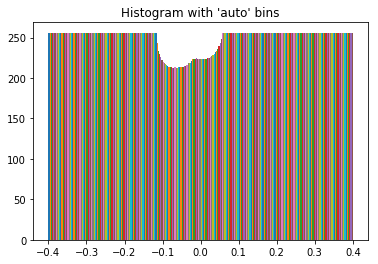

In [20]:
img_2d = img_3d[5]

plt.hist(img_2d, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()




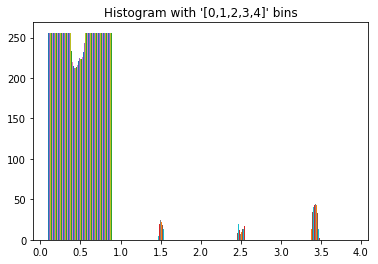

In [21]:
plt.hist(img_2d, bins=[0,1,2,3,4])  # arguments are passed to np.histogram
plt.title("Histogram with '[0,1,2,3,4]' bins")
plt.show()




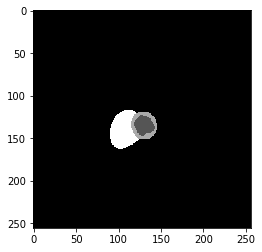

In [22]:
plt.imshow(img_2d)

(256, 256, 16)


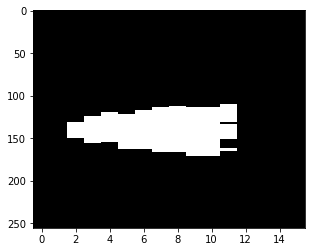

In [23]:
# switch axes
img_3d_t = img_3d.T
print(img_3d_t.shape)
plt.imshow(img_3d_t[100], aspect=0.05)



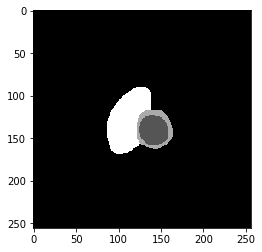

In [18]:
def multi_slice_viewer(volume):
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    """Go to the previous slice."""
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    """Go to the next slice."""
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
multi_slice_viewer(img_3d)

Contour:1086


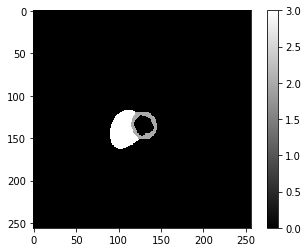

In [219]:
m2 = mask_slice(img)
plt.imshow(m2)
plt.colorbar()

In [24]:
IMG_DIM = 50

from skimage.transform import resize
resized = resize(transformed, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)

    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)

    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()
    
plot_cube(resized)

NameError: name 'transformed' is not defined

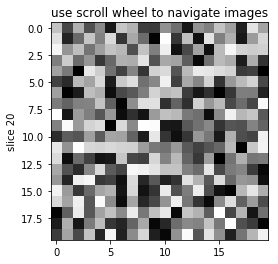

In [25]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt


class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.random.rand(20, 20, 40)

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

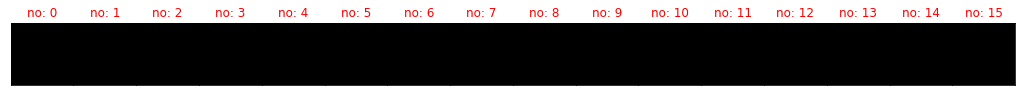

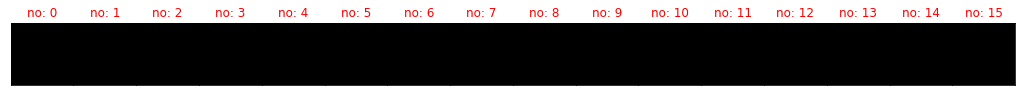

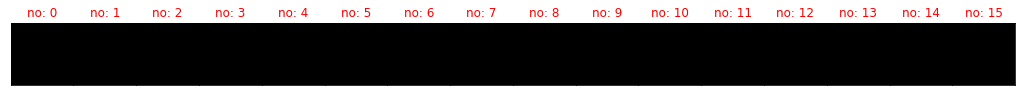

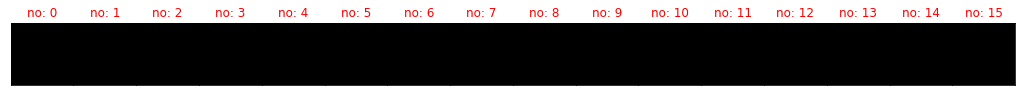

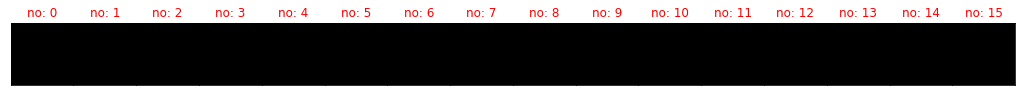

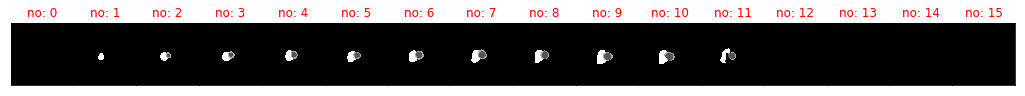

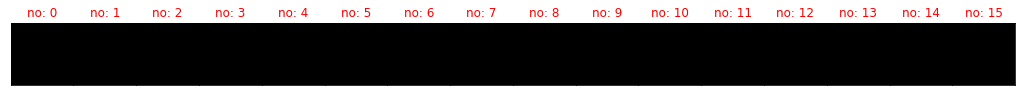

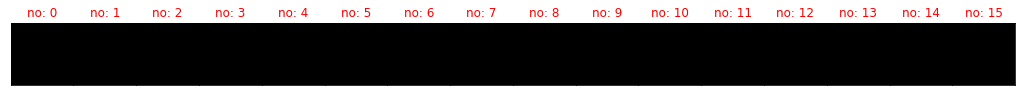

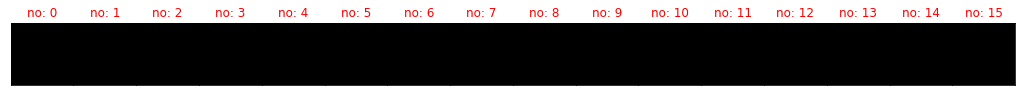

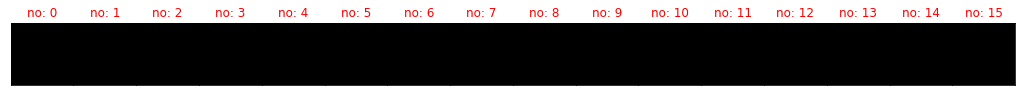

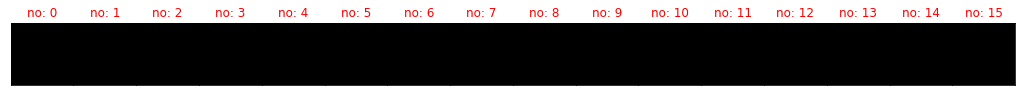

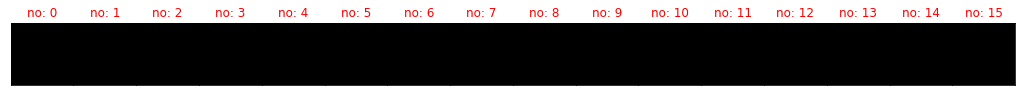

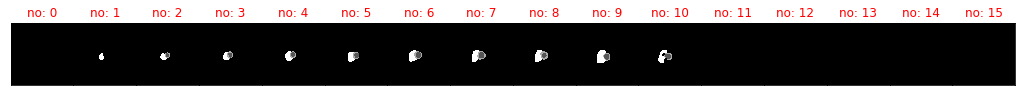

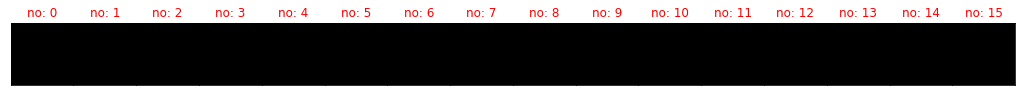

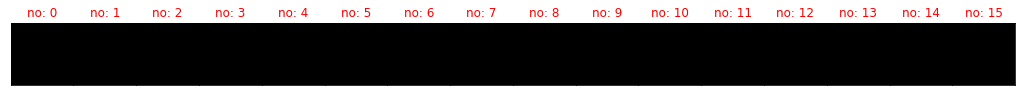

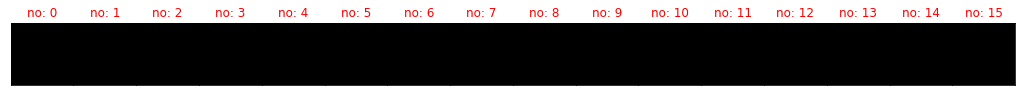

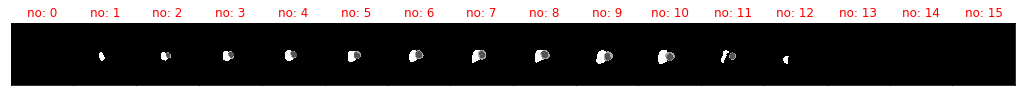

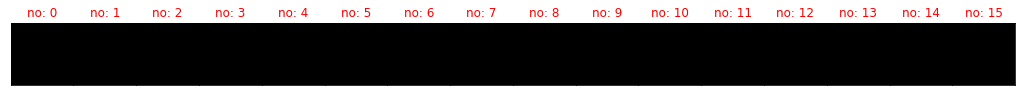

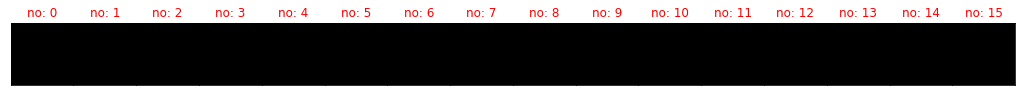

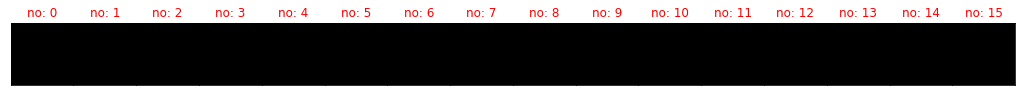

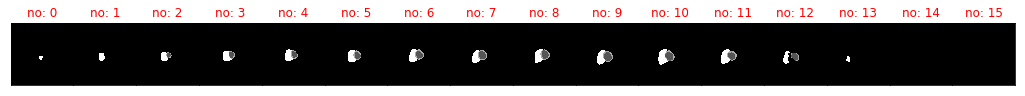

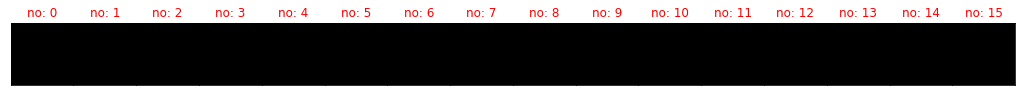

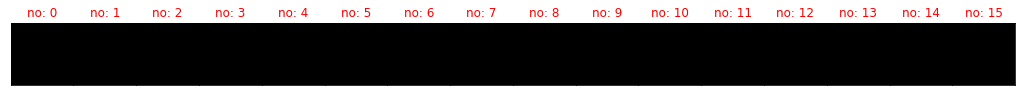

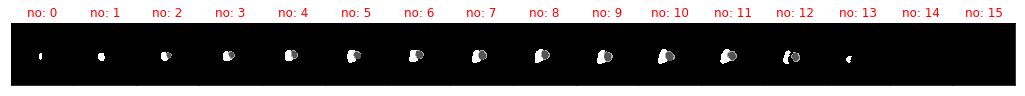

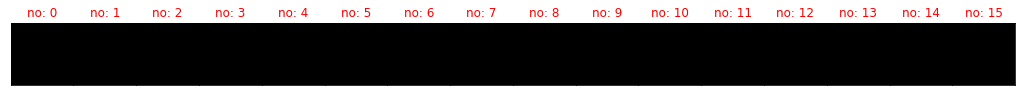

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]